
SixHumpCamel: 2D


In [1]:
pip install pyGPGO


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pyGPGO: filename=pyGPGO-0.5.1-py3-none-any.whl size=19879 sha256=70654d725dde3dc5e209f967796f6fa3ec292fc2ef81b1bc2983420b0b3b9b78
  Stored in directory: /root/.cache/pip/wheels/c8/5d/0b/2160114e2f1b87791c51b66cf07f89831dbb6f49167950316f
Successfully built pyGPGO


In [2]:
### Import:

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import itertools

from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential

from joblib import Parallel, delayed
from numpy.linalg import solve, cholesky
from scipy.spatial.distance import cdist
from scipy.optimize import minimize
from scipy.stats import norm
import time

warnings.filterwarnings("ignore", category=RuntimeWarning)


In [3]:
### Inputs:

func = 'SixHumpCamel'
n_test = 500
eps = 1e-08

util = 'EI'

n_init = 5 # random initialisations
iters = 20
opt = True

In [4]:
### Objective Function - SixHumpCamel(x) 2-D:

def objfunc(x1_training, x2_training):
        return operator * ((4 - 2.1 * x1_training ** 2 + 1 / 3 * x1_training ** 4) * x1_training ** 2 +
                (x1_training * x2_training) + (-4 + 4 * x2_training ** 2) * x2_training ** 2)
    
# Constraints:
lb_x1 = -3
ub_x1 = +3
    
lb_x2 = -2
ub_x2 = +2

# Input array dimension(s):
dim = 2

# 2-D inputs' parameter bounds:
param = {'x1_training': ('cont', [lb_x1, ub_x1]),
             'x2_training': ('cont', [lb_x2, ub_x2])}

# True y bounds:
operator = -1
y_global_orig = -1.0316 # targets global minimum

# Test data:
x1_test = np.linspace(lb_x1, ub_x1, n_test) 
x2_test = np.linspace(lb_x2, ub_x2, n_test)
  
x_test = np.column_stack((x1_test,x2_test))


In [5]:
n_start_AcqFunc = iters
inverse = -1


In [6]:
### Cumulative Regret Calculators:

def min_max_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list
  
def acqFuncExact(x):
    new_array = []
    x = np.array(x) 
    for i, num in enumerate(x):
            new_array = x[:-2][::-3]
    return new_array[::-1]

def acqFuncApprox(x):
    new_array = []
    x = np.array(x) 
    for i, num in enumerate(x):
            new_array = x[:-1][::-3]
    return new_array[::-1]


In [7]:
### Surrogate derivatives: 

cov_func = squaredExponential()

def kronDelta(X, Xstar):                     # Kronecker's Delta method
    return cdist(X, Xstar) < np.finfo(np.float32).eps

def se(X, Xstar, sigmaf, l, sigman):         # S.E. kernel method
    return sigmaf * np.exp(-0.5 * cdist(X, Xstar) ** 2 / l ** 2) + sigman * kronDelta(X, Xstar)

def delta(X, Xstar):                         # Distance between training X and test Xstar vectors
    return (X - Xstar)
   
def der_covmat(X, Xstar, sigmaf, l, sigman): # Covariance matrix derivative terms (i.e. exact, first-order)
    nx = len(X)
    ny = len(Xstar)
    return np.round(np.array([(delta(np.atleast_2d(i), np.atleast_2d(j))[0] * se(np.atleast_2d(i), np.atleast_2d(j), sigmaf, l, sigman)[0]).sum() for (i, j) in itertools.product(X, Xstar)]).reshape(nx, ny), 8)

class dGaussianProcess(GaussianProcess):    # Via inheritance, also optimises hyperparameters when opt = TRUE
    
    def AcqGrad(self, Xstar):               # Method returning exact, first-order derivatives of the GP's posterior mean and standard deviation
        Xstar = np.atleast_2d(Xstar)
        Kstar = self.covfunc.K(self.X, Xstar).T
        
        dKstar = der_covmat(self.X, Xstar, self.covfunc.sigmaf, self.covfunc.l, self.covfunc.sigman).T
        alpha_Kstar = np.dot(np.linalg.inv(self.K + (self.covfunc.sigman**2) * np.eye(len(self.X))), Kstar.T)
        
        dm = np.dot(dKstar, self.alpha)
        ds = -2 * np.dot(dKstar, alpha_Kstar)
        
        return dm, ds           


In [8]:
### Add exact acquisition function gradient as attribute:

class Acquisition_grad(Acquisition):    
    def __init__(self, mode, eps=eps, **params):
        
        self.params = params
        self.eps = eps

        mode_dict = {
            'EI': self.EI
        }

        self.f = mode_dict[mode]
    
    def EI(self, tau, mean, std, ds, dm):
        gamma = (mean - tau - self.eps) / (std + self.eps)
        gamma_h = (mean - tau) / (std + self.eps)
        dsdx = ds / (2 * (std + self.eps))
        dmdx = (dm - gamma * dsdx) / (std + self.eps)
        
        f = (std + self.eps) * (gamma * norm.cdf(gamma) + norm.pdf(gamma))
        df1 = f / (std + self.eps) * dsdx 
        df2 = (std + self.eps) * norm.cdf(gamma) * dmdx
        df = (df1 + df2)[0]
        df_arr = []

        for j in range(0, dim):
          df_arr.append(df)
        return f, np.asarray(df_arr).transpose()
        
    def d_eval(self, tau, mean, std, ds, dm):
    
        return self.f(tau, mean, std, ds, dm, **self.params)
        

In [9]:
## GPGO_multi: 

class GPGO_multi(GPGO):
    n_start = n_start_AcqFunc

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t        Exact EI: StdDev. x \t Approx EI: StdDev. x '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}\t {:3}'
 
    def acqfuncExact(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df
   
    def acqfuncApprox(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f
   
    def _optimizeAcq(self, method='L-BFGS-B', n_start=n_start_AcqFunc):
        
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        f_best_min = min(f_best)

        self.x_best = x_best
        self.f_best = f_best
        self.f_best_min = f_best_min
        self.x_best_std = np.std(x_best)
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr        
        self.history.append(self.x_best_std)

        x_best_exact = np.empty((n_start, len(self.parameter_key)))
        f_best_exact = np.empty((n_start,))
        opt_exact = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExact,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best_exact = np.array([res.x for res in opt_exact])
        f_best_exact = np.array([np.atleast_1d(res.fun)[0] for res in opt_exact])
        f_best_min_exact = min(f_best_exact)

        self.x_best_exact = x_best_exact
        self.f_best_exact = f_best_exact
        self.f_best_min_exact = f_best_min_exact
        self.x_best_std_exact = np.std(x_best_exact)
        self.best_exact = x_best_exact[np.argmin(f_best_exact)]
        self.start_points_arr = start_points_arr
        self.history.append(self.x_best_std_exact)

    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, '', ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        min_acqfunc = str(self.f_best_min)
        min_acqfunc_exact = str(self.f_best_min_exact)
        x_best_std = str(self.x_best_std)
        x_best_std_exact = str(self.x_best_std_exact)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            x_best_std = BOLD + OKGREEN + x_best_std + ENDC
            x_best_std_exact = BOLD + OKGREEN + x_best_std_exact + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, x_best_std_exact, x_best_std))
        
    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [10]:
## dGPGO:

class dGPGO(GPGO):
    n_start = n_start_AcqFunc

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t        Exact EI: StdDev. x \t Approx EI: StdDev. x '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}\t {:3}'

    def acqfuncExact(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df
   
    def acqfuncApprox(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f

    def d_optimizeAcq(self, method='L-BFGS-B', n_start=n_start_AcqFunc):
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExact,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        f_best_min = min(f_best)

        self.x_best = x_best
        self.f_best = f_best
        self.f_best_min = f_best_min
        self.x_best_std = np.std(x_best)
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr
        self.history.append(self.x_best_std)

        x_best_approx = np.empty((n_start, len(self.parameter_key)))
        f_best_approx = np.empty((n_start,))
        opt_approx = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best_approx = np.array([res.x for res in opt_approx])
        f_best_approx = np.array([np.atleast_1d(res.fun)[0] for res in opt_approx])
        f_best_min_approx = min(f_best_approx)

        self.x_best_approx = x_best_approx
        self.f_best_approx = f_best_approx
        self.f_best_min_approx = f_best_min_approx
        self.x_best_std_approx = np.std(x_best_approx)
        self.best_approx = x_best_approx[np.argmin(f_best_approx)]
        self.start_points_arr = start_points_arr
        self.history.append(self.x_best_std_approx)
    
    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, '', ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        min_acqfunc = str(self.f_best_min)
        min_acqfunc_approx = str(self.f_best_min_approx)
        x_best_std = str(self.x_best_std)
        x_best_std_approx = str(self.x_best_std_approx)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            x_best_std = BOLD + OKGREEN + x_best_std + ENDC
            x_best_std_approx = BOLD + OKGREEN + x_best_std_approx + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, x_best_std, x_best_std_approx))

    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self.d_optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [11]:
###Reproducible set-seeds:

run_num_1 = 1
run_num_2 = 2
run_num_3 = 3
run_num_4 = 4
run_num_5 = 5
run_num_6 = 6
run_num_7 = 7
run_num_8 = 8
run_num_9 = 9
run_num_10 = 10
run_num_11 = 11
run_num_12 = 12
run_num_13 = 13
run_num_14 = 14
run_num_15 = 15
run_num_16 = 16
run_num_17 = 17
run_num_18 = 18
run_num_19 = 19
run_num_20 = 20


In [12]:
start_approx = time.time()
start_approx


1659612480.4326177

In [13]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_1)
surrogate_approx_1 = dGaussianProcess(cov_func, optimize=opt)

approx_1 = GPGO_multi(surrogate_approx_1, Acquisition_grad(util), objfunc, param)
approx_1.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [-0.49786797  0.88129797]	 -0.2650082867644827	 -0.2650082867644827	    	    
init	 [-2.99931375 -0.79066971]	 110.13991869176735	 -0.2650082867644827	    	    
init	 [-2.11946466 -1.63064562]	 26.90935479429681	 -0.2650082867644827	    	    
init	 [-1.88243873 -0.61775709]	 2.8558363102363344	 -0.2650082867644827	    	    
init	 [-0.61939515  0.15526694]	 1.0540522096005847	 -0.2650082867644827	    	    
1  	 [-1.19209699 -0.31431616]	 2.418604194089478	 -0.2650082867644827	 1.6259849529408084	 1.7035230032707442
2  	 [-0.22547579  1.70883971]	 22.240849622618942	 -0.2650082867644827	 1.4889897173202988	 1.4890874794051756
3  	 [ 2.48246431 -1.70176508]	 40.65026890583644	 -0.2650082867644827	 1.62197359920602	 1.9473931780875409
4  	 [3. 2.]	 162.89999999999998	 -0.2650082867644827	 1.930240913760408	 2.072154232289843
5  	 [-3.  2.]	 150.89999999999998	 -0.2650082867

In [14]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_2)
surrogate_approx_2 = dGaussianProcess(cov_func, optimize=opt)

approx_2 = GPGO_multi(surrogate_approx_2, Acquisition_grad(util), objfunc, param)
approx_2.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [-0.38403059 -1.89629507]	 38.61280125654363	 0.011939608840498828	    	    
init	 [ 0.29797487 -0.25871043]	 0.011939608840498828	 0.011939608840498828	    	    
init	 [-0.47779319 -0.67866072]	 0.1381453419305213	 0.011939608840498828	    	    
init	 [-1.7721082   0.47708387]	 0.626144759281101	 0.011939608840498828	    	    
init	 [-1.20207196 -0.9326909 ]	 3.0693811601417798	 0.011939608840498828	    	    
1  	 [-0.39431495 -0.08552524]	 0.5771014397304058	 0.011939608840498828	 1.803501211220942	 1.9034947058038223
2  	 [ 1.85203999 -0.19665791]	 1.9520503538370169	 0.011939608840498828	 1.4427745079126393	 1.7186076633303458
3  	 [0.73875436 2.        ]	 51.08923695270019	 0.011939608840498828	 1.982974700117786	 2.136254739254116
4  	 [ 3. -2.]	 150.89999999999998	 0.011939608840498828	 1.9012658329212662	 2.4091982853498126
5  	 [-3.  2.]	 150.89999999999998	 0.

In [15]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_3)
surrogate_approx_3 = dGaussianProcess(cov_func, optimize=opt)

approx_3 = GPGO_multi(surrogate_approx_3, Acquisition_grad(util), objfunc, param)
approx_3.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [0.30478742 0.83259129]	 -0.2431922946563294	 -0.2431922946563294	    	    
init	 [-1.25457157  0.04331042]	 2.3313310458730996	 -0.2431922946563294	    	    
init	 [2.35768173 1.58517236]	 33.54152175045586	 -0.2431922946563294	    	    
init	 [-2.24648814 -1.17102849]	 14.214109412296352	 -0.2431922946563294	    	    
init	 [-2.69119678 -0.23676063]	 45.87579771712209	 -0.2431922946563294	    	    
1  	 [-0.2309166   0.29148206]	 -0.1709116466540207	 -0.2431922946563294	 1.0744224330334209	 1.0885109152295513
2	 [-0.39661823  0.8583581 ]	 -0.5376272709585427	 -0.5376272709585427	 1.2707048522811504	 1.2063268423706097
3  	 [-0.20567488  0.24083004]	 -0.10259756511713929	 -0.5376272709585427	 1.3357896014145199	 1.1450531387652194
4  	 [-0.53334406  1.38957064]	 7.4244290218126	 -0.5376272709585427	 1.1284782322182954	 1.6304248981194738
5  	 [ 0.02178157 -0.23983294]	

In [16]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_4)
surrogate_approx_4 = dGaussianProcess(cov_func, optimize=opt)

approx_4= GPGO_multi(surrogate_approx_4, Acquisition_grad(util), objfunc, param)
approx_4.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [2.80217903 0.188929  ]	 63.70212732873661	 2.3196402150601703	    	    
init	 [2.83610616 0.85926397]	 71.43837110827245	 2.3196402150601703	    	    
init	 [ 1.18637295 -1.13564202]	 2.5463267765341566	 2.3196402150601703	    	    
init	 [ 2.85764673 -1.97507898]	 113.76785286351424	 2.3196402150601703	    	    
init	 [-1.48210583 -0.26083387]	 2.3196402150601703	 2.3196402150601703	    	    
1	 [ 0.13819595 -1.09159236]	 0.8378729983345513	 0.8378729983345513	 1.6086530256174443	 1.9647796212899875
2	 [ 0.16279961 -1.07402786]	 0.6381310288891437	 0.6381310288891437	 1.6697730324037454	 1.721118499942757
3  	 [-3.  2.]	 150.89999999999998	 0.6381310288891437	 1.6149848408050111	 2.0003681633400823
4  	 [-3. -2.]	 162.89999999999998	 0.6381310288891437	 1.9809533900886191	 1.8540432064892878
5	 [-0.26848645 -0.13256574]	 0.24408538465589355	 0.24408538465589355	 1.414

In [17]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_5)
surrogate_approx_5 = dGaussianProcess(cov_func, optimize=opt)

approx_5 = GPGO_multi(surrogate_approx_5, Acquisition_grad(util), objfunc, param)
approx_5.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [-1.66804097  1.48292922]	 10.126030408244933	 -0.6512780061070701	    	    
init	 [-1.75968507  1.67444363]	 19.4300499315822	 -0.6512780061070701	    	    
init	 [-0.06953287  0.44697545]	 -0.6512780061070701	 -0.6512780061070701	    	    
init	 [1.59544714 0.07367195]	 2.168775388880503	 -0.6512780061070701	    	    
init	 [-1.21919699 -1.24911509]	 7.420330936884148	 -0.6512780061070701	    	    
1  	 [0.32583964 1.00818374]	 0.7967371894748262	 -0.6512780061070701	 1.9046164288609266	 2.0731160710029983
2  	 [ 3. -2.]	 150.89999999999998	 -0.6512780061070701	 1.9682637293881837	 2.0072908192107417
3  	 [3. 2.]	 162.89999999999998	 -0.6512780061070701	 2.107439591594674	 2.008191368315554
4  	 [0.4254109 0.0313057]	 0.6664962659071133	 -0.6512780061070701	 1.5075158566041935	 1.4182018650952102
5  	 [-3. -2.]	 162.89999999999998	 -0.6512780061070701	 1.6565737979914

In [18]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_6)
surrogate_approx_6 = dGaussianProcess(cov_func, optimize=opt)

approx_6 = GPGO_multi(surrogate_approx_6, Acquisition_grad(util), objfunc, param)
approx_6.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [ 2.35716091 -0.67208078]	 11.995980169715628	 -0.3096187466378422	    	    
init	 [ 1.92737474 -1.8332135 ]	 31.167927894156623	 -0.3096187466378422	    	    
init	 [-2.35405992  0.38020826]	 13.013381745677465	 -0.3096187466378422	    	    
init	 [ 0.17890417 -0.32477029]	 -0.3096187466378422	 -0.3096187466378422	    	    
init	 [-0.9875529   0.49007773]	 0.9989196280666852	 -0.3096187466378422	    	    
1  	 [0.19888424 0.91003727]	 -0.23327669759911474	 -0.3096187466378422	 1.7561864617434624	 1.5394646779870995
2	 [0.11616366 0.67403998]	 -0.8597635887265809	 -0.8597635887265809	 1.8238284568976508	 1.6847731113106093
3  	 [0.13061593 0.7053691 ]	 -0.8402109420699337	 -0.8597635887265809	 1.9985587168954253	 1.8085421500422298
4  	 [0.13127649 0.70691014]	 -0.8388869269372223	 -0.8597635887265809	 1.8715154643151062	 1.5450019188462722
5  	 [0.1317468  0.70800797]	

In [19]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_7)
surrogate_approx_7 = dGaussianProcess(cov_func, optimize=opt)

approx_7 = GPGO_multi(surrogate_approx_7, Acquisition_grad(util), objfunc, param)
approx_7.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [-2.54215026  1.11967517]	 26.53843863832488	 -0.46481072558790276	    	    
init	 [-0.36954461  0.89386071]	 -0.46481072558790276	 -0.46481072558790276	    	    
init	 [2.86793707 0.15398348]	 76.66051064695093	 -0.46481072558790276	    	    
init	 [ 0.00672278 -1.71179547]	 22.613010892757885	 -0.46481072558790276	    	    
init	 [-1.38936612e+00 -4.69996698e-04]	 2.294585534557751	 -0.46481072558790276	    	    
1  	 [0.14003009 1.65200772]	 19.18503288903285	 -0.46481072558790276	 1.24513328419618	 1.430159897823947
2  	 [-2.0069916  -0.34039291]	 4.09787808897999	 -0.46481072558790276	 1.476826716896781	 1.476826716896781
3  	 [-0.47109136  0.58002622]	 -0.3783020334196958	 -0.46481072558790276	 1.89882552004107	 1.8058739559260735
4	 [-0.14196887  0.42856901]	 -0.5808180226262771	 -0.5808180226262771	 1.6809679676908515	 1.7869812196687334
5  	 [-0.3520866   0.517

In [20]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_8)
surrogate_approx_8 = dGaussianProcess(cov_func, optimize=opt)

approx_8 = GPGO_multi(surrogate_approx_8, Acquisition_grad(util), objfunc, param)
approx_8.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [2.24057642 1.87416265]	 48.82879577505094	 0.03190064766213015	    	    
init	 [2.21516724 0.12342277]	 8.660623551418242	 0.03190064766213015	    	    
init	 [-1.60363003 -1.95440478]	 48.28332373939171	 0.03190064766213015	    	    
init	 [-0.41718709 -0.39059456]	 0.2801229037700297	 0.03190064766213015	    	    
init	 [ 0.13604803 -0.08643282]	 0.03190064766213015	 0.03190064766213015	    	    
1  	 [-0.77086886  0.84272184]	 0.23242422233356008	 0.03190064766213015	 1.2463959421143596	 1.6397809866271555
2  	 [-3.  2.]	 150.89999999999998	 0.03190064766213015	 1.3864870116347838	 2.122191385946795
3	 [-0.24360329  0.39126551]	 -0.38387907993258125	 -0.38387907993258125	 1.208273468877501	 1.281369700138018
4  	 [-0.24416435  0.38712394]	 -0.3730716827364074	 -0.38387907993258125	 1.516028363848094	 1.7525812019543376
5  	 [-0.24497437  0.38151423]	 -0.358372139486

In [21]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_9)
surrogate_approx_9 = dGaussianProcess(cov_func, optimize=opt)

approx_9 = GPGO_multi(surrogate_approx_9, Acquisition_grad(util), objfunc, param)
approx_9.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [-2.93775508  0.00749837]	 92.35857237145763	 1.395407492769129	    	    
init	 [-0.02536024 -1.46468188]	 9.867672894921913	 1.395407492769129	    	    
init	 [-2.14733349 -1.1257653 ]	 10.24680089963123	 1.395407492769129	    	    
init	 [-0.48895092 -1.00759533]	 1.395407492769129	 1.395407492769129	    	    
init	 [-2.49564209 -0.61800544]	 24.58298635463645	 1.395407492769129	    	    
1  	 [0.19950386 1.29272168]	 4.899980086595864	 1.395407492769129	 1.6064182666594051	 1.5389731582832187
2  	 [ 3.         -0.21547441]	 108.07648258328325	 1.395407492769129	 2.1090613991294034	 1.9514596538970168
3  	 [-1.44939862  2.        ]	 47.32689265929798	 1.395407492769129	 1.602180587697333	 1.5008456459057682
4  	 [-1.57484893 -2.        ]	 53.238148922947346	 1.395407492769129	 1.7105775517083037	 1.5924359153163827
5	 [-0.51196048 -0.15338005]	 0.8967863571366157	 0.8

In [22]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_10)
surrogate_approx_10 = dGaussianProcess(cov_func, optimize=opt)

approx_10 = GPGO_multi(surrogate_approx_10, Acquisition_grad(util), objfunc, param)
approx_10.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [ 1.62792386 -1.9169922 ]	 38.25414770674631	 0.7775687473184012	    	    
init	 [0.80188941 0.99521553]	 2.552651714051803	 0.7775687473184012	    	    
init	 [-0.00895793 -1.10081342]	 1.0367630165263393	 0.7775687473184012	    	    
init	 [-1.81162281  1.04212285]	 0.7775687473184012	 0.7775687473184012	    	    
init	 [-1.98533498 -1.64664074]	 25.383481436170044	 0.7775687473184012	    	    
1  	 [3. 2.]	 162.89999999999998	 0.7775687473184012	 1.589201390238439	 1.8094099745112386
2  	 [-3.  2.]	 150.89999999999998	 0.7775687473184012	 1.1746340026289581	 1.4519410806466009
3  	 [ 3.         -0.56605295]	 106.33084289570883	 0.7775687473184012	 1.4501655019646518	 1.4509757541350945
4	 [-0.7532562   0.62545309]	 0.23063111601765074	 0.23063111601765074	 1.4835390894105003	 1.487102111973559
5  	 [-0.77425408  0.62943664]	 0.270785017851114	 0.23063111601765074	 1.

In [23]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_11)
surrogate_approx_11 = dGaussianProcess(cov_func, optimize=opt)

approx_11 = GPGO_multi(surrogate_approx_11, Acquisition_grad(util), objfunc, param)
approx_11.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [-1.91838187 -1.92209903]	 46.39910375151002	 -0.6254688257880329	    	    
init	 [-0.22068884  0.89973572]	 -0.6254688257880329	 -0.6254688257880329	    	    
init	 [-0.47877837 -0.05829161]	 0.8249470187639529	 -0.6254688257880329	    	    
init	 [-2.92331511 -0.05051357]	 88.99028404075307	 -0.6254688257880329	    	    
init	 [2.65083991 1.40318036]	 51.423425402262914	 -0.6254688257880329	    	    
1  	 [ 1.79052491 -2.        ]	 46.642439808247566	 -0.6254688257880329	 1.4011124206698906	 1.5072091725693435
2  	 [-0.41855111  2.        ]	 47.800981468687965	 -0.6254688257880329	 1.1203855999971721	 1.2464105413810684
3  	 [ 0.09051383 -0.00503656]	 0.03207290039322645	 -0.6254688257880329	 1.6605053929572062	 1.660303778426899
4  	 [ 0.08003266 -0.00212966]	 0.025346253591978556	 -0.6254688257880329	 1.33999842700247	 1.2929972529976865
5  	 [ 0.07460426 -0.0005853

In [24]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_12)
surrogate_approx_12 = dGaussianProcess(cov_func, optimize=opt)

approx_12 = GPGO_multi(surrogate_approx_12, Acquisition_grad(util), objfunc, param)
approx_12.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [-2.07502295  0.96019879]	 2.6185857163917037	 1.9967735906956543	    	    
init	 [-1.42010991  0.13495757]	 1.9967735906956543	 1.9967735906956543	    	    
init	 [-2.91255023  1.67498803]	 101.67816714332157	 1.9967735906956543	    	    
init	 [ 2.40428912 -1.86631429]	 47.44624883788006	 1.9967735906956543	    	    
init	 [ 2.74169602 -1.45116271]	 58.32400185681089	 1.9967735906956543	    	    
1	 [-1.337878    0.82388566]	 0.36879704199305774	 0.36879704199305774	 2.248323829684019	 1.9748983555376431
2  	 [1.74301928 2.        ]	 53.60261104768335	 0.36879704199305774	 2.1165994669609614	 1.8219068502224032
3  	 [-3. -2.]	 162.89999999999998	 0.36879704199305774	 1.648873806105735	 1.584432154335971
4  	 [-0.16291724 -2.        ]	 48.430529410549696	 0.36879704199305774	 1.3139540382584085	 1.231212767828399
5	 [-1.49393438  0.64566136]	 0.23577047222883796	 0.235

In [25]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_13)
surrogate_approx_13 = dGaussianProcess(cov_func, optimize=opt)

approx_13 = GPGO_multi(surrogate_approx_13, Acquisition_grad(util), objfunc, param)
approx_13.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [ 1.66621446 -1.04983512]	 0.752930921147986	 0.752930921147986	    	    
init	 [1.9456712  1.86299679]	 41.05776363102951	 0.752930921147986	    	    
init	 [ 2.83560668 -0.18620301]	 69.0134544723513	 0.752930921147986	    	    
init	 [0.65425478 1.10210606]	 3.117452174069064	 0.752930921147986	    	    
init	 [0.84968007 0.88807292]	 2.006601529383926	 0.752930921147986	    	    
1  	 [ 0.69815135 -1.5584218 ]	 14.280544136905649	 0.752930921147986	 1.1482809677702306	 1.2038349978134193
2  	 [-3.  2.]	 150.89999999999998	 0.752930921147986	 1.604511611483205	 1.945960703330493
3  	 [-3. -2.]	 162.89999999999998	 0.752930921147986	 1.6769508063821563	 1.7890870466749633
4  	 [-1.32681869 -1.1815997 ]	 6.132474358637779	 0.752930921147986	 1.5354991965821498	 1.5354991965821498
5	 [-0.19817028  0.59883805]	 -0.8848366775560662	 -0.8848366775560662	 1.623664321955077	

In [26]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_14)
surrogate_approx_14 = dGaussianProcess(cov_func, optimize=opt)

approx_14 = GPGO_multi(surrogate_approx_14, Acquisition_grad(util), objfunc, param)
approx_14.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [0.08366006 1.09266021]	 1.0453292732107575	 -1.029299726828387	    	    
init	 [ 2.22256611 -1.96781221]	 48.81113313056442	 -1.029299726828387	    	    
init	 [-1.14158445  1.83041496]	 31.794043287944216	 -1.029299726828387	    	    
init	 [ 0.07870027 -0.7268623 ]	 -1.029299726828387	 -1.029299726828387	    	    
init	 [ 0.23519962 -1.11498023]	 1.161934062902255	 -1.029299726828387	    	    
1  	 [-1.4544454   0.80460528]	 0.13632292703505466	 -1.029299726828387	 1.503658355512916	 1.503658355512916
2  	 [-1.62889462 -1.85708112]	 38.86111235771161	 -1.029299726828387	 1.5374298505922563	 1.5374298505922563
3  	 [-0.15386684 -1.39029353]	 7.520441668707877	 -1.029299726828387	 1.3235846389965387	 1.3235846389965387
4  	 [0.42921709 0.75222473]	 0.007928470491904593	 -1.029299726828387	 1.4304797833357905	 1.4304797833357905
5  	 [ 0.10283639 -0.51837162]	 -0.797258

In [27]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_15)
surrogate_approx_15 = dGaussianProcess(cov_func, optimize=opt)

approx_15 = GPGO_multi(surrogate_approx_15, Acquisition_grad(util), objfunc, param)
approx_15.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [ 2.09290618 -1.2844163 ]	 6.84252100896936	 2.1163170846379233	    	    
init	 [-2.67382071 -0.55384622]	 43.69785230561242	 2.1163170846379233	    	    
init	 [-1.34759443  0.1200009 ]	 2.1163170846379233	 2.1163170846379233	    	    
init	 [-1.16448651 -0.78210256]	 2.3544087277459513	 2.1163170846379233	    	    
init	 [-2.32955234 -1.00040394]	 15.469119251600274	 2.1163170846379233	    	    
1  	 [-0.31230925  1.23090386]	 3.107966059914712	 2.1163170846379233	 1.687086957433018	 1.3725080719744793
2  	 [3. 2.]	 162.89999999999998	 2.1163170846379233	 1.9689169227194863	 2.159163358748201
3  	 [-3.  2.]	 150.89999999999998	 2.1163170846379233	 1.5244896269228267	 1.7566788538905187
4	 [-0.27070757 -0.29550408]	 0.04318936470340434	 0.04318936470340434	 1.2584926269796997	 1.1077601442572051
5  	 [-0.27822716 -0.29112708]	 0.06792524325045923	 0.04318936470340434	 

In [28]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_16)
surrogate_approx_16 = dGaussianProcess(cov_func, optimize=opt)

approx_16 = GPGO_multi(surrogate_approx_16, Acquisition_grad(util), objfunc, param)
approx_16.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [-1.66025353  0.09265337]	 1.8632773736203017	 1.8632773736203017	    	    
init	 [ 0.30420874 -1.8175922 ]	 30.24114424375299	 1.8632773736203017	    	    
init	 [-0.83562699 -1.10767623]	 3.922061281476444	 1.8632773736203017	    	    
init	 [ 1.13235697 -1.3450743 ]	 6.7121671493737685	 1.8632773736203017	    	    
init	 [-2.5780508   1.76404344]	 53.42443470756798	 1.8632773736203017	    	    
1  	 [ 3.         -0.04378922]	 108.7609770576423	 1.8632773736203017	 1.9087975856071429	 2.08835013992957
2  	 [-3. -2.]	 162.89999999999998	 1.8632773736203017	 1.8461488456194866	 1.7861234372284738
3  	 [0.53255234 2.        ]	 50.03824175828417	 1.8632773736203017	 1.5090977757183406	 1.4710223583189566
4  	 [-0.91745731 -0.01809519]	 2.093131287996447	 1.8632773736203017	 1.5109500784169099	 1.632840187152938
5  	 [-1.03036552 -0.06609219]	 2.329255444267561	 1.86327737

In [29]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_17)
surrogate_approx_17 = dGaussianProcess(cov_func, optimize=opt)

approx_17 = GPGO_multi(surrogate_approx_17, Acquisition_grad(util), objfunc, param)
approx_17.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [-1.23200998  0.12234702]	 2.189206652278967	 1.7722768782964888	    	    
init	 [-1.85087528 -1.72839857]	 29.406067820453675	 1.7722768782964888	    	    
init	 [1.72191276 0.62533409]	 2.2113401446731897	 1.7722768782964888	    	    
init	 [0.82512538 0.30241158]	 1.7722768782964888	 1.7722768782964888	    	    
init	 [-2.7656225  -0.56874558]	 57.5922315952177	 1.7722768782964888	    	    
1	 [-0.55712466  1.08599903]	 1.2904712864486778	 1.2904712864486778	 1.8475063655280535	 1.7331668124315933
2  	 [ 3. -2.]	 150.89999999999998	 1.2904712864486778	 1.5761781225970999	 1.9462159326996975
3  	 [3. 2.]	 162.89999999999998	 1.2904712864486778	 1.6786783020055558	 1.7221001906866216
4  	 [0.92241907 0.18981443]	 2.1246079247590357	 1.2904712864486778	 1.489847328801347	 1.6400744912221719
5  	 [-1.56013619  2.        ]	 46.98120007046126	 1.2904712864486778	 1.2712885

In [30]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_18)
surrogate_approx_18 = dGaussianProcess(cov_func, optimize=opt)

approx_18 = GPGO_multi(surrogate_approx_18, Acquisition_grad(util), objfunc, param)
approx_18.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [0.90224545 0.02181349]	 2.062169771852028	 2.062169771852028	    	    
init	 [ 2.27160883 -1.2726391 ]	 11.64729291207819	 2.062169771852028	    	    
init	 [2.11339841 1.00054514]	 7.792128760671214	 2.062169771852028	    	    
init	 [0.99661    1.95158179]	 46.96206222999227	 2.062169771852028	    	    
init	 [-1.45818946 -1.8867763 ]	 41.4190528039297	 2.062169771852028	    	    
1  	 [-3.  2.]	 150.89999999999998	 2.062169771852028	 1.5736723200128686	 1.903386920817331
2	 [ 0.51933718 -0.47021367]	 -0.0004387791505781058	 -0.0004387791505781058	 1.3196260131879207	 1.4723520687035303
3	 [ 0.46722715 -0.47742819]	 -0.15039958734018488	 -0.15039958734018488	 1.5161322425605213	 1.3411464123298895
4	 [ 0.44976542 -0.47473192]	 -0.1858510183284554	 -0.1858510183284554	 1.5105336280106982	 1.517632858949149
5	 [ 0.44009002 -0.47280303]	 -0.2039971659151858	 -0.20399716

In [31]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_19)
surrogate_approx_19 = dGaussianProcess(cov_func, optimize=opt)

approx_19 = GPGO_multi(surrogate_approx_19, Acquisition_grad(util), objfunc, param)
approx_19.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [-2.41479839  1.04499887]	 15.890475442873509	 6.578088852480828	    	    
init	 [-1.51837216 -1.44747325]	 13.520839509777993	 6.578088852480828	    	    
init	 [-1.01132062 -1.66800174]	 23.772158573571232	 6.578088852480828	    	    
init	 [1.03186249 1.22637519]	 6.578088852480828	 6.578088852480828	    	    
init	 [2.89645149 0.54264294]	 83.31828503667734	 6.578088852480828	    	    
1  	 [-0.04594902  2.        ]	 47.916537858903055	 6.578088852480828	 1.802734884445024	 2.008826734194486
2  	 [ 1.6626862 -2.       ]	 46.725988988445636	 6.578088852480828	 2.0456992470228412	 2.1616891517021726
3  	 [-3. -2.]	 162.89999999999998	 6.578088852480828	 1.4270999028333438	 1.6282661338758833
4	 [-0.30754482 -0.24340017]	 0.21175163798172386	 0.21175163798172386	 1.3966128840599505	 1.397180114910923
5	 [-0.23874691 -0.2198156 ]	 0.08978273567635284	 0.0897827356763528

In [32]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_20)
surrogate_approx_20 = dGaussianProcess(cov_func, optimize=opt)

approx_20 = GPGO_multi(surrogate_approx_20, Acquisition_grad(util), objfunc, param)
approx_20.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [0.52878481 1.59085491]	 17.29968374481291	 1.5037392797834441	    	    
init	 [2.34918438 1.26334991]	 20.91583049569433	 1.5037392797834441	    	    
init	 [-2.78466249  0.76703033]	 57.06253405225224	 1.5037392797834441	    	    
init	 [-0.72791435  0.07404378]	 1.5037392797834441	 1.5037392797834441	    	    
init	 [ 0.94770879 -1.22459913]	 3.9766737661914173	 1.5037392797834441	    	    
1  	 [-1.16287628 -2.        ]	 52.71897154250457	 1.5037392797834441	 1.3239021933320114	 1.4180856387988787
2  	 [ 3. -2.]	 150.89999999999998	 1.5037392797834441	 1.42611185225855	 2.015310389833849
3	 [ 0.44491632 -0.32008893]	 0.2018495674177776	 0.2018495674177776	 1.4248196601796814	 1.4158191243120724
4  	 [ 0.44440557 -0.31347918]	 0.21688159575915594	 0.2018495674177776	 1.567531999408363	 1.5308636516202778
5  	 [ 0.44473352 -0.31307705]	 0.21870336094154053	 0.20184956

In [33]:
end_approx = time.time()
end_approx

time_approx = end_approx - start_approx
time_approx

start_exact = time.time()
start_exact

1659613158.5285084

In [34]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_1)
surrogate_exact_1 = dGaussianProcess(cov_func, optimize=opt)

exact_1 = dGPGO(surrogate_exact_1, Acquisition_grad(util), objfunc, param)
exact_1.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [-0.49786797  0.88129797]	 -0.2650082867644827	 -0.2650082867644827	    	    
init	 [-2.99931375 -0.79066971]	 110.13991869176735	 -0.2650082867644827	    	    
init	 [-2.11946466 -1.63064562]	 26.90935479429681	 -0.2650082867644827	    	    
init	 [-1.88243873 -0.61775709]	 2.8558363102363344	 -0.2650082867644827	    	    
init	 [-0.61939515  0.15526694]	 1.0540522096005847	 -0.2650082867644827	    	    
1  	 [-1.0222508  -0.56767233]	 1.9738149569435763	 -0.2650082867644827	 1.6259849529408084	 1.7035230032707442
2  	 [-1.26808267 -0.11971967]	 2.4833208094638186	 -0.2650082867644827	 1.4607354264475703	 1.5349363414405452
3  	 [-0.4682545   1.65874906]	 19.278966809435275	 -0.2650082867644827	 1.625637030267677	 1.7129951817249094
4  	 [0.57640459 0.14873338]	 1.108587133549329	 -0.2650082867644827	 1.8473784057474754	 1.8799547720491965
5  	 [3. 2.]	 162.89999999999

In [35]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_2)
surrogate_exact_2 = dGaussianProcess(cov_func, optimize=opt)

exact_2 = dGPGO(surrogate_exact_2, Acquisition_grad(util), objfunc, param)
exact_2.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [-0.38403059 -1.89629507]	 38.61280125654363	 0.011939608840498828	    	    
init	 [ 0.29797487 -0.25871043]	 0.011939608840498828	 0.011939608840498828	    	    
init	 [-0.47779319 -0.67866072]	 0.1381453419305213	 0.011939608840498828	    	    
init	 [-1.7721082   0.47708387]	 0.626144759281101	 0.011939608840498828	    	    
init	 [-1.20207196 -0.9326909 ]	 3.0693811601417798	 0.011939608840498828	    	    
1  	 [-0.31993922 -0.13822595]	 0.35705703278801193	 0.011939608840498828	 1.803501211220942	 1.9034947058038223
2  	 [ 2.04712486 -0.34678071]	 3.2819773046713774	 0.011939608840498828	 1.4639477227166415	 1.7149178698682075
3  	 [0.87539145 2.        ]	 51.73283837601235	 0.011939608840498828	 2.0231150742119595	 2.14754184134238
4  	 [-3. -2.]	 162.89999999999998	 0.011939608840498828	 1.909414068063048	 2.340352727451027
5  	 [3.         1.37226805]	 119.66888

In [36]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_3)
surrogate_exact_3 = dGaussianProcess(cov_func, optimize=opt)

exact_3 = dGPGO(surrogate_exact_3, Acquisition_grad(util), objfunc, param)
exact_3.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [0.30478742 0.83259129]	 -0.2431922946563294	 -0.2431922946563294	    	    
init	 [-1.25457157  0.04331042]	 2.3313310458730996	 -0.2431922946563294	    	    
init	 [2.35768173 1.58517236]	 33.54152175045586	 -0.2431922946563294	    	    
init	 [-2.24648814 -1.17102849]	 14.214109412296352	 -0.2431922946563294	    	    
init	 [-2.69119678 -0.23676063]	 45.87579771712209	 -0.2431922946563294	    	    
1  	 [-0.24615031  0.33088407]	 -0.23671242014455512	 -0.2431922946563294	 1.0744224330334209	 1.0885109152295513
2	 [-0.26381503  0.4354689 ]	 -0.4612393470974674	 -0.4612393470974674	 1.2683766897887134	 1.2009806966391312
3  	 [-0.51799266  1.2341212 ]	 3.4758193603861836	 -0.4612393470974674	 1.3373928527582413	 1.1468022653669705
4  	 [-0.0673234  -0.21593135]	 -0.14518543952304563	 -0.4612393470974674	 1.1785167255950022	 1.1212265582224528
5  	 [ 0.05023894 -0.293192

In [37]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_4)
surrogate_exact_4 = dGaussianProcess(cov_func, optimize=opt)

exact_4 = dGPGO(surrogate_exact_4, Acquisition_grad(util), objfunc, param)
exact_4.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [2.80217903 0.188929  ]	 63.70212732873661	 2.3196402150601703	    	    
init	 [2.83610616 0.85926397]	 71.43837110827245	 2.3196402150601703	    	    
init	 [ 1.18637295 -1.13564202]	 2.5463267765341566	 2.3196402150601703	    	    
init	 [ 2.85764673 -1.97507898]	 113.76785286351424	 2.3196402150601703	    	    
init	 [-1.48210583 -0.26083387]	 2.3196402150601703	 2.3196402150601703	    	    
1	 [-0.19248638 -0.29673967]	 -0.118746904624908	 -0.118746904624908	 1.6086530256174443	 1.9647796212899875
2	 [ 0.0771446 -0.9683799]	 -0.2844404270558513	 -0.2844404270558513	 1.4637018186714632	 1.6496717312960714
3  	 [ 0.15454763 -1.42856043]	 8.369638169079648	 -0.2844404270558513	 1.6052355013483148	 1.7444763079380028
4  	 [-0.59840288  1.94539575]	 42.167704564580156	 -0.2844404270558513	 1.7209835865269563	 1.907651352026891
5  	 [-3. -2.]	 162.89999999999998	 -0.28444

In [38]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_5)
surrogate_exact_5 = dGaussianProcess(cov_func, optimize=opt)

exact_5 = dGPGO(surrogate_exact_5, Acquisition_grad(util), objfunc, param)
exact_5.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [-1.66804097  1.48292922]	 10.126030408244933	 -0.6512780061070701	    	    
init	 [-1.75968507  1.67444363]	 19.4300499315822	 -0.6512780061070701	    	    
init	 [-0.06953287  0.44697545]	 -0.6512780061070701	 -0.6512780061070701	    	    
init	 [1.59544714 0.07367195]	 2.168775388880503	 -0.6512780061070701	    	    
init	 [-1.21919699 -1.24911509]	 7.420330936884148	 -0.6512780061070701	    	    
1  	 [0.27873899 1.08341635]	 1.4162287546962613	 -0.6512780061070701	 1.9046164288609266	 2.0731160710029983
2  	 [3. 2.]	 162.89999999999998	 -0.6512780061070701	 1.9578852286537753	 2.0948609708471597
3  	 [ 2.22867989 -2.        ]	 52.44856270446538	 -0.6512780061070701	 1.658757518255385	 1.8176558994045657
4  	 [0.27494103 0.1639579 ]	 0.23095496884843886	 -0.6512780061070701	 1.516092305931419	 1.5111381589434454
5  	 [-3. -2.]	 162.89999999999998	 -0.651278006107070

In [39]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_6)
surrogate_exact_6 = dGaussianProcess(cov_func, optimize=opt)

exact_6 = dGPGO(surrogate_exact_6, Acquisition_grad(util), objfunc, param)
exact_6.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [ 2.35716091 -0.67208078]	 11.995980169715628	 -0.3096187466378422	    	    
init	 [ 1.92737474 -1.8332135 ]	 31.167927894156623	 -0.3096187466378422	    	    
init	 [-2.35405992  0.38020826]	 13.013381745677465	 -0.3096187466378422	    	    
init	 [ 0.17890417 -0.32477029]	 -0.3096187466378422	 -0.3096187466378422	    	    
init	 [-0.9875529   0.49007773]	 0.9989196280666852	 -0.3096187466378422	    	    
1  	 [0.14564833 0.99656045]	 0.20177881687152865	 -0.3096187466378422	 1.7561864617434624	 1.5394646779870995
2  	 [3. 2.]	 162.89999999999998	 -0.3096187466378422	 2.101037296569909	 2.05498898434892
3	 [-0.20642557  0.73264737]	 -0.9791695830839107	 -0.9791695830839107	 1.8025212981297425	 1.6989965164226464
4  	 [-0.1567979   0.53674031]	 -0.8074587029374714	 -0.9791695830839107	 1.6961505899045275	 1.5823137775601843
5  	 [-0.08928664  0.26902626]	 -0.26081320603

In [40]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_7)
surrogate_exact_7 = dGaussianProcess(cov_func, optimize=opt)

exact_7 = dGPGO(surrogate_exact_7, Acquisition_grad(util), objfunc, param)
exact_7.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [-2.54215026  1.11967517]	 26.53843863832488	 -0.46481072558790276	    	    
init	 [-0.36954461  0.89386071]	 -0.46481072558790276	 -0.46481072558790276	    	    
init	 [2.86793707 0.15398348]	 76.66051064695093	 -0.46481072558790276	    	    
init	 [ 0.00672278 -1.71179547]	 22.613010892757885	 -0.46481072558790276	    	    
init	 [-1.38936612e+00 -4.69996698e-04]	 2.294585534557751	 -0.46481072558790276	    	    
1  	 [0.1310842  1.64834684]	 18.945381193780257	 -0.46481072558790276	 1.24513328419618	 1.430159897823947
2  	 [-2.0069916  -0.34039291]	 4.09787808897999	 -0.46481072558790276	 1.476826716896781	 1.476826716896781
3  	 [-0.62752856  0.70661994]	 -0.17355017380823146	 -0.46481072558790276	 1.8961587043369237	 1.8029925847846435
4	 [-0.29852921  0.52826691]	 -0.6224198225575582	 -0.6224198225575582	 1.8719980144897486	 1.781920240745369
5  	 [-3. -2.]	 162.8

In [41]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_8)
surrogate_exact_8 = dGaussianProcess(cov_func, optimize=opt)

exact_8 = dGPGO(surrogate_exact_8, Acquisition_grad(util), objfunc, param)
exact_8.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [2.24057642 1.87416265]	 48.82879577505094	 0.03190064766213015	    	    
init	 [2.21516724 0.12342277]	 8.660623551418242	 0.03190064766213015	    	    
init	 [-1.60363003 -1.95440478]	 48.28332373939171	 0.03190064766213015	    	    
init	 [-0.41718709 -0.39059456]	 0.2801229037700297	 0.03190064766213015	    	    
init	 [ 0.13604803 -0.08643282]	 0.03190064766213015	 0.03190064766213015	    	    
1	 [-0.57246742  0.6534526 ]	 -0.25569579328253045	 -0.25569579328253045	 1.2463959421143596	 1.6397809866271555
2  	 [-1.18831557  1.21804401]	 3.8222330710419667	 -0.25569579328253045	 1.3819434779080972	 1.671580124884549
3  	 [0.04982841 0.04620172]	 0.003700531824410219	 -0.25569579328253045	 1.2068665806813608	 1.570816800958729
4  	 [ 1.5233709  -1.90834873]	 37.71548823920068	 -0.25569579328253045	 1.5066470778646164	 1.973091290133215
5	 [-0.33912575  0.43440778]	 -

In [42]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_9)
surrogate_exact_9 = dGaussianProcess(cov_func, optimize=opt)

exact_9 = dGPGO(surrogate_exact_9, Acquisition_grad(util), objfunc, param)
exact_9.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [-2.93775508  0.00749837]	 92.35857237145763	 1.395407492769129	    	    
init	 [-0.02536024 -1.46468188]	 9.867672894921913	 1.395407492769129	    	    
init	 [-2.14733349 -1.1257653 ]	 10.24680089963123	 1.395407492769129	    	    
init	 [-0.48895092 -1.00759533]	 1.395407492769129	 1.395407492769129	    	    
init	 [-2.49564209 -0.61800544]	 24.58298635463645	 1.395407492769129	    	    
1  	 [0.30007956 2.        ]	 48.94356541468191	 1.395407492769129	 1.6064182666594051	 1.5389731582832187
2  	 [3.         0.35932676]	 109.528200874667	 1.395407492769129	 1.874405311467603	 1.950567378804555
3  	 [ 1.74044958 -1.84128563]	 31.323868720181455	 1.395407492769129	 1.441205258985459	 1.3986993788846274
4  	 [-1.55536773 -2.        ]	 53.216714029899045	 1.395407492769129	 1.5454680817450175	 1.5591566349236696
5	 [-0.45357128 -0.14814099]	 0.7182664624905546	 0.718266

In [43]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_10)
surrogate_exact_10 = dGaussianProcess(cov_func, optimize=opt)

exact_10 = dGPGO(surrogate_exact_10, Acquisition_grad(util), objfunc, param)
exact_10.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [ 1.62792386 -1.9169922 ]	 38.25414770674631	 0.7775687473184012	    	    
init	 [0.80188941 0.99521553]	 2.552651714051803	 0.7775687473184012	    	    
init	 [-0.00895793 -1.10081342]	 1.0367630165263393	 0.7775687473184012	    	    
init	 [-1.81162281  1.04212285]	 0.7775687473184012	 0.7775687473184012	    	    
init	 [-1.98533498 -1.64664074]	 25.383481436170044	 0.7775687473184012	    	    
1  	 [3. 2.]	 162.89999999999998	 0.7775687473184012	 1.589201390238439	 1.8094099745112386
2  	 [-2.52977022  2.        ]	 69.90104466534116	 0.7775687473184012	 1.1746340026289581	 1.4519410806466009
3  	 [-0.96096779  0.29985852]	 1.5500307910683613	 0.7775687473184012	 1.457698049786842	 1.6966201140977315
4  	 [ 3.         -0.28423181]	 107.75026028666434	 0.7775687473184012	 1.6555392301969527	 1.9155637003009254
5	 [-0.348341    0.78170365]	 -0.7679201385345631	 -0.76792

In [44]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_11)
surrogate_exact_11 = dGaussianProcess(cov_func, optimize=opt)

exact_11 = dGPGO(surrogate_exact_11, Acquisition_grad(util), objfunc, param)
exact_11.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [-1.91838187 -1.92209903]	 46.39910375151002	 -0.6254688257880329	    	    
init	 [-0.22068884  0.89973572]	 -0.6254688257880329	 -0.6254688257880329	    	    
init	 [-0.47877837 -0.05829161]	 0.8249470187639529	 -0.6254688257880329	    	    
init	 [-2.92331511 -0.05051357]	 88.99028404075307	 -0.6254688257880329	    	    
init	 [2.65083991 1.40318036]	 51.423425402262914	 -0.6254688257880329	    	    
1  	 [0.1162043  0.20936558]	 -0.08968928579150665	 -0.6254688257880329	 1.4011124206698906	 1.5072091725693435
2  	 [-0.26857992  1.50634431]	 11.391644241601337	 -0.6254688257880329	 1.0826218563554062	 1.3748726126047464
3  	 [ 1.46188583 -1.88617587]	 35.8505521757125	 -0.6254688257880329	 1.651416146008017	 1.817712801682867
4  	 [ 0.19155584 -0.03220303]	 0.13365101792458087	 -0.6254688257880329	 1.3456185031542787	 1.371070816866985
5  	 [0.05153275 0.10757978]	 -0

In [45]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_12)
surrogate_exact_12 = dGaussianProcess(cov_func, optimize=opt)

exact_12 = dGPGO(surrogate_exact_12, Acquisition_grad(util), objfunc, param)
exact_12.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [-2.07502295  0.96019879]	 2.6185857163917037	 1.9967735906956543	    	    
init	 [-1.42010991  0.13495757]	 1.9967735906956543	 1.9967735906956543	    	    
init	 [-2.91255023  1.67498803]	 101.67816714332157	 1.9967735906956543	    	    
init	 [ 2.40428912 -1.86631429]	 47.44624883788006	 1.9967735906956543	    	    
init	 [ 2.74169602 -1.45116271]	 58.32400185681089	 1.9967735906956543	    	    
1	 [-1.15648604  0.74752304]	 0.5401694705946541	 0.5401694705946541	 2.248323829684019	 1.9748983555376431
2  	 [1.83110409 2.        ]	 54.030151566854705	 0.5401694705946541	 2.171627199407564	 1.8377378106480446
3  	 [-3. -2.]	 162.89999999999998	 0.5401694705946541	 1.699038310669307	 1.6106449554487428
4  	 [-0.1634226 -2.       ]	 48.432181477152	 0.5401694705946541	 1.3211135579367483	 1.2335229673668344
5	 [-1.47701762  0.78295106]	 0.08738741316331844	 0.08738741316

In [46]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_13)
surrogate_exact_13 = dGaussianProcess(cov_func, optimize=opt)

exact_13 = dGPGO(surrogate_exact_13, Acquisition_grad(util), objfunc, param)
exact_13.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [ 1.66621446 -1.04983512]	 0.752930921147986	 0.752930921147986	    	    
init	 [1.9456712  1.86299679]	 41.05776363102951	 0.752930921147986	    	    
init	 [ 2.83560668 -0.18620301]	 69.0134544723513	 0.752930921147986	    	    
init	 [0.65425478 1.10210606]	 3.117452174069064	 0.752930921147986	    	    
init	 [0.84968007 0.88807292]	 2.006601529383926	 0.752930921147986	    	    
1  	 [ 0.4943127  -1.24330367]	 3.617106922875216	 0.752930921147986	 1.1482809677702306	 1.2038349978134193
2  	 [-0.83460691  1.3144168 ]	 5.811882953645614	 0.752930921147986	 1.8815016005926022	 1.592869964360895
3  	 [-3. -2.]	 162.89999999999998	 0.752930921147986	 1.7882934601251652	 1.9561831169162682
4  	 [ 1.11089436 -2.        ]	 48.14281330125023	 0.752930921147986	 1.4904283199359507	 1.9167288606770563
5  	 [ 2.10322474 -1.94085306]	 43.06366123572329	 0.752930921147986	 1.696

In [47]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_14)
surrogate_exact_14 = dGaussianProcess(cov_func, optimize=opt)

exact_14 = dGPGO(surrogate_exact_14, Acquisition_grad(util), objfunc, param)
exact_14.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [0.08366006 1.09266021]	 1.0453292732107575	 -1.029299726828387	    	    
init	 [ 2.22256611 -1.96781221]	 48.81113313056442	 -1.029299726828387	    	    
init	 [-1.14158445  1.83041496]	 31.794043287944216	 -1.029299726828387	    	    
init	 [ 0.07870027 -0.7268623 ]	 -1.029299726828387	 -1.029299726828387	    	    
init	 [ 0.23519962 -1.11498023]	 1.161934062902255	 -1.029299726828387	    	    
1  	 [-1.4544454   0.80460528]	 0.13632292703505466	 -1.029299726828387	 1.503658355512916	 1.503658355512916
2  	 [-1.62889462 -1.85708112]	 38.86111235771161	 -1.029299726828387	 1.5374298505922563	 1.5374298505922563
3  	 [-0.15386684 -1.39029353]	 7.520441668707877	 -1.029299726828387	 1.3235846389965387	 1.3235846389965387
4  	 [0.42921709 0.75222473]	 0.007928470491904593	 -1.029299726828387	 1.4304797833357905	 1.4304797833357905
5  	 [ 0.17242163 -0.54461366]	 -0.811353

In [48]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_15)
surrogate_exact_15 = dGaussianProcess(cov_func, optimize=opt)

exact_15 = dGPGO(surrogate_exact_15, Acquisition_grad(util), objfunc, param)
exact_15.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [ 2.09290618 -1.2844163 ]	 6.84252100896936	 2.1163170846379233	    	    
init	 [-2.67382071 -0.55384622]	 43.69785230561242	 2.1163170846379233	    	    
init	 [-1.34759443  0.1200009 ]	 2.1163170846379233	 2.1163170846379233	    	    
init	 [-1.16448651 -0.78210256]	 2.3544087277459513	 2.1163170846379233	    	    
init	 [-2.32955234 -1.00040394]	 15.469119251600274	 2.1163170846379233	    	    
1	 [-0.21638275  1.08971893]	 0.837475442441042	 0.837475442441042	 1.687086957433018	 1.3725080719744793
2  	 [3. 2.]	 162.89999999999998	 0.837475442441042	 1.9631753150999465	 2.0425444457643627
3  	 [-1.96941567  2.        ]	 47.43342240539559	 0.837475442441042	 1.5403553542748882	 1.7185987471812307
4  	 [-0.17804804 -2.        ]	 48.4808006875014	 0.837475442441042	 1.3172156010179834	 1.066978145531064
5  	 [0.70088083 0.45442263]	 1.1607617601927824	 0.837475442441042

In [49]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_16)
surrogate_exact_16 = dGaussianProcess(cov_func, optimize=opt)

exact_16 = dGPGO(surrogate_exact_16, Acquisition_grad(util), objfunc, param)
exact_16.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [-1.66025353  0.09265337]	 1.8632773736203017	 1.8632773736203017	    	    
init	 [ 0.30420874 -1.8175922 ]	 30.24114424375299	 1.8632773736203017	    	    
init	 [-0.83562699 -1.10767623]	 3.922061281476444	 1.8632773736203017	    	    
init	 [ 1.13235697 -1.3450743 ]	 6.7121671493737685	 1.8632773736203017	    	    
init	 [-2.5780508   1.76404344]	 53.42443470756798	 1.8632773736203017	    	    
1  	 [ 3.         -0.03166106]	 108.80101115742967	 1.8632773736203017	 1.9087975856071429	 2.08835013992957
2  	 [-3. -2.]	 162.89999999999998	 1.8632773736203017	 1.8471872664105302	 1.7864102788733391
3  	 [0.53458945 2.        ]	 50.04858828808778	 1.8632773736203017	 1.5088545907563833	 1.4720178802655093
4  	 [-1.10134941  0.07301427]	 2.25541265535764	 1.8632773736203017	 1.5109939546938678	 1.5740192206167833
5	 [-0.38436994 -0.07390268]	 0.5528776934672587	 0.55287769

In [50]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_17)
surrogate_exact_17 = dGaussianProcess(cov_func, optimize=opt)

exact_17 = dGPGO(surrogate_exact_17, Acquisition_grad(util), objfunc, param)
exact_17.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [-1.23200998  0.12234702]	 2.189206652278967	 1.7722768782964888	    	    
init	 [-1.85087528 -1.72839857]	 29.406067820453675	 1.7722768782964888	    	    
init	 [1.72191276 0.62533409]	 2.2113401446731897	 1.7722768782964888	    	    
init	 [0.82512538 0.30241158]	 1.7722768782964888	 1.7722768782964888	    	    
init	 [-2.7656225  -0.56874558]	 57.5922315952177	 1.7722768782964888	    	    
1  	 [-0.94844345  1.77369891]	 27.464707626764916	 1.7722768782964888	 1.8475063655280535	 1.7331668124315933
2  	 [ 2.16747806 -2.        ]	 50.670774669928775	 1.7722768782964888	 1.6242463708035557	 2.197880546594921
3  	 [3. 2.]	 162.89999999999998	 1.7722768782964888	 1.8273012694051465	 1.6866923178638684
4  	 [0.97958062 0.2221369 ]	 2.229137979813862	 1.7722768782964888	 1.5952959609827362	 1.727403275521201
5	 [-0.08334248 -0.32165678]	 -0.3165435517895191	 -0.3165435517

In [51]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_18)
surrogate_exact_18 = dGaussianProcess(cov_func, optimize=opt)

exact_18 = dGPGO(surrogate_exact_18, Acquisition_grad(util), objfunc, param)
exact_18.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [0.90224545 0.02181349]	 2.062169771852028	 2.062169771852028	    	    
init	 [ 2.27160883 -1.2726391 ]	 11.64729291207819	 2.062169771852028	    	    
init	 [2.11339841 1.00054514]	 7.792128760671214	 2.062169771852028	    	    
init	 [0.99661    1.95158179]	 46.96206222999227	 2.062169771852028	    	    
init	 [-1.45818946 -1.8867763 ]	 41.4190528039297	 2.062169771852028	    	    
1  	 [-2.66531515  1.40819569]	 45.982813537937645	 2.062169771852028	 1.5736723200128686	 1.903386920817331
2  	 [3.        0.6031628]	 109.78368431836117	 2.062169771852028	 1.3147760148745133	 1.5503952784317807
3  	 [1.89592609 0.6375228 ]	 2.969704029748832	 2.062169771852028	 1.4184424205217094	 1.4184424205217094
4  	 [-0.32173714 -1.49268739]	 11.817714263649087	 2.062169771852028	 1.5210965405894012	 1.5210965405894012
5	 [-0.73927187  0.43212922]	 0.686338663645771	 0.686338663645

In [52]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_19)
surrogate_exact_19 = dGaussianProcess(cov_func, optimize=opt)

exact_19 = dGPGO(surrogate_exact_19, Acquisition_grad(util), objfunc, param)
exact_19.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [-2.41479839  1.04499887]	 15.890475442873509	 6.578088852480828	    	    
init	 [-1.51837216 -1.44747325]	 13.520839509777993	 6.578088852480828	    	    
init	 [-1.01132062 -1.66800174]	 23.772158573571232	 6.578088852480828	    	    
init	 [1.03186249 1.22637519]	 6.578088852480828	 6.578088852480828	    	    
init	 [2.89645149 0.54264294]	 83.31828503667734	 6.578088852480828	    	    
1  	 [0.10116931 2.        ]	 48.243059900228204	 6.578088852480828	 1.802734884445024	 2.008826734194486
2  	 [ 1.4154914  -1.88944898]	 36.29074861563762	 6.578088852480828	 1.9303001045414583	 2.150154120606879
3  	 [-3. -2.]	 162.89999999999998	 6.578088852480828	 1.4372222344321	 1.599155198919188
4	 [-0.2606682 -0.1399839]	 0.22184398731126448	 0.22184398731126448	 1.4041654336884455	 1.4793264221703768
5	 [ 0.19813133 -0.17803827]	 -0.004238427612070855	 -0.004238427612070855	 

In [53]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_20)
surrogate_exact_20 = dGaussianProcess(cov_func, optimize=opt)

exact_20 = dGPGO(surrogate_exact_20, Acquisition_grad(util), objfunc, param)
exact_20.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [0.52878481 1.59085491]	 17.29968374481291	 1.5037392797834441	    	    
init	 [2.34918438 1.26334991]	 20.91583049569433	 1.5037392797834441	    	    
init	 [-2.78466249  0.76703033]	 57.06253405225224	 1.5037392797834441	    	    
init	 [-0.72791435  0.07404378]	 1.5037392797834441	 1.5037392797834441	    	    
init	 [ 0.94770879 -1.22459913]	 3.9766737661914173	 1.5037392797834441	    	    
1  	 [-1.18115566 -2.        ]	 52.76057163057528	 1.5037392797834441	 1.3239021933320114	 1.4180856387988787
2  	 [ 2.59213852 -1.65326133]	 47.84960809826183	 1.5037392797834441	 1.4256178623338602	 2.0152754644213333
3	 [ 0.22139217 -0.162917  ]	 0.05163369461120049	 0.05163369461120049	 1.4281451246146106	 1.3847694614229211
4	 [-0.33967677  0.28979802]	 0.02792003913677127	 0.02792003913677127	 1.5751232433854268	 1.5431826745806823
5	 [ 0.04615981 -0.02633349]	 0.00452594562

In [54]:
end_exact = time.time()
end_exact

time_exact = end_exact - start_exact
time_exact


623.5541229248047

In [55]:
### Simple regret minimization: run number = 1

approx_output_1 = np.append(np.min(-approx_1.GP.y[0:n_init]),-approx_1.GP.y[n_init:(n_init+iters)]) 
exact_output_1 = np.append(np.min(-exact_1.GP.y[0:n_init]),-exact_1.GP.y[n_init:(n_init+iters)]) 

regret_approx_1 = np.log(approx_output_1 - y_global_orig)
regret_exact_1 = np.log(exact_output_1 - y_global_orig)

simple_regret_approx_1 = min_max_array(regret_approx_1)
simple_regret_exact_1 = min_max_array(regret_exact_1)

min_simple_regret_approx_1 = min(simple_regret_approx_1)
min_simple_regret_exact_1 = min(simple_regret_exact_1)

min_simple_regret_approx_1, min_simple_regret_exact_1


(-0.2658009358573259, -0.2658009358573259)

In [56]:
### Simple regret minimization: run number = 2

approx_output_2 = np.append(np.min(-approx_2.GP.y[0:n_init]),-approx_2.GP.y[n_init:(n_init+iters)]) 
exact_output_2 = np.append(np.min(-exact_2.GP.y[0:n_init]),-exact_2.GP.y[n_init:(n_init+iters)]) 

regret_approx_2 = np.log(approx_output_2 - y_global_orig)
regret_exact_2 = np.log(exact_output_2 - y_global_orig)

simple_regret_approx_2 = min_max_array(regret_approx_2)
simple_regret_exact_2 = min_max_array(regret_exact_2)

min_simple_regret_approx_2 = min(simple_regret_approx_2)
min_simple_regret_exact_2 = min(simple_regret_exact_2)

min_simple_regret_approx_2, min_simple_regret_exact_2


(0.03335866621503685, -0.09141497463908152)

In [57]:
### Simple regret minimization: run number = 3

approx_output_3 = np.append(np.min(-approx_3.GP.y[0:n_init]),-approx_3.GP.y[n_init:(n_init+iters)]) 
exact_output_3 = np.append(np.min(-exact_3.GP.y[0:n_init]),-exact_3.GP.y[n_init:(n_init+iters)]) 

regret_approx_3 = np.log(approx_output_3 - y_global_orig)
regret_exact_3 = np.log(exact_output_3 - y_global_orig)

simple_regret_approx_3 = min_max_array(regret_approx_3)
simple_regret_exact_3 = min_max_array(regret_exact_3)

min_simple_regret_approx_3 = min(simple_regret_approx_3)
min_simple_regret_exact_3 = min(simple_regret_exact_3)

min_simple_regret_approx_3, min_simple_regret_exact_3

(-0.7052749676875513, -1.5614956503396664)

In [58]:
### Simple regret minimization: run number = 4

approx_output_4 = np.append(np.min(-approx_4.GP.y[0:n_init]),-approx_4.GP.y[n_init:(n_init+iters)]) 
exact_output_4 = np.append(np.min(-exact_4.GP.y[0:n_init]),-exact_4.GP.y[n_init:(n_init+iters)]) 

regret_approx_4 = np.log(approx_output_4 - y_global_orig)
regret_exact_4 = np.log(exact_output_4 - y_global_orig)

simple_regret_approx_4 = min_max_array(regret_approx_4)
simple_regret_exact_4 = min_max_array(regret_exact_4)

min_simple_regret_approx_4 = min(simple_regret_approx_4)
min_simple_regret_exact_4 = min(simple_regret_exact_4)

min_simple_regret_approx_4, min_simple_regret_exact_4

(-5.073457322415554, -1.5236556203622285)

In [59]:
### Simple regret minimization: run number = 5

approx_output_5 = np.append(np.min(-approx_5.GP.y[0:n_init]),-approx_5.GP.y[n_init:(n_init+iters)]) 
exact_output_5 = np.append(np.min(-exact_5.GP.y[0:n_init]),-exact_5.GP.y[n_init:(n_init+iters)]) 

regret_approx_5 = np.log(approx_output_5 - y_global_orig)
regret_exact_5 = np.log(exact_output_5 - y_global_orig)

simple_regret_approx_5 = min_max_array(regret_approx_5)
simple_regret_exact_5 = min_max_array(regret_exact_5)

min_simple_regret_approx_5 = min(simple_regret_approx_5)
min_simple_regret_exact_5 = min(simple_regret_exact_5)

min_simple_regret_approx_5, min_simple_regret_exact_5

(-1.8466634597692166, -2.4166011145215123)

In [60]:
### Simple regret minimization: run number = 6

approx_output_6 = np.append(np.min(-approx_6.GP.y[0:n_init]),-approx_6.GP.y[n_init:(n_init+iters)]) 
exact_output_6 = np.append(np.min(-exact_6.GP.y[0:n_init]),-exact_6.GP.y[n_init:(n_init+iters)]) 

regret_approx_6 = np.log(approx_output_6 - y_global_orig)
regret_exact_6 = np.log(exact_output_6 - y_global_orig)

simple_regret_approx_6 = min_max_array(regret_approx_6)
simple_regret_exact_6 = min_max_array(regret_exact_6)

min_simple_regret_approx_6 = min(simple_regret_approx_6)
min_simple_regret_exact_6 = min(simple_regret_exact_6)

min_simple_regret_approx_6, min_simple_regret_exact_6

(-1.7612123519962217, -2.948268380567984)

In [61]:
### Simple regret minimization: run number = 7

approx_output_7 = np.append(np.min(-approx_7.GP.y[0:n_init]),-approx_7.GP.y[n_init:(n_init+iters)]) 
exact_output_7 = np.append(np.min(-exact_7.GP.y[0:n_init]),-exact_7.GP.y[n_init:(n_init+iters)]) 

regret_approx_7 = np.log(approx_output_7 - y_global_orig)
regret_exact_7 = np.log(exact_output_7 - y_global_orig)

simple_regret_approx_7 = min_max_array(regret_approx_7)
simple_regret_exact_7 = min_max_array(regret_exact_7)

min_simple_regret_approx_7 = min(simple_regret_approx_7)
min_simple_regret_exact_7 = min(simple_regret_exact_7)

min_simple_regret_approx_7, min_simple_regret_exact_7

(-0.7967714768221764, -0.8935996883007996)

In [62]:
### Simple regret minimization: run number = 8

approx_output_8 = np.append(np.min(-approx_8.GP.y[0:n_init]),-approx_8.GP.y[n_init:(n_init+iters)]) 
exact_output_8 = np.append(np.min(-exact_8.GP.y[0:n_init]),-exact_8.GP.y[n_init:(n_init+iters)]) 

regret_approx_8 = np.log(approx_output_8 - y_global_orig)
regret_exact_8 = np.log(exact_output_8 - y_global_orig)

simple_regret_approx_8 = min_max_array(regret_approx_8)
simple_regret_exact_8 = min_max_array(regret_exact_8)

min_simple_regret_approx_8 = min(simple_regret_approx_8)
min_simple_regret_exact_8 = min(simple_regret_exact_8)

min_simple_regret_approx_8, min_simple_regret_exact_8

(-0.4342953543069644, -1.6667913180754064)

In [63]:
### Simple regret minimization: run number = 9

approx_output_9 = np.append(np.min(-approx_9.GP.y[0:n_init]),-approx_9.GP.y[n_init:(n_init+iters)]) 
exact_output_9 = np.append(np.min(-exact_9.GP.y[0:n_init]),-exact_9.GP.y[n_init:(n_init+iters)]) 

regret_approx_9 = np.log(approx_output_9 - y_global_orig)
regret_exact_9 = np.log(exact_output_9 - y_global_orig)

simple_regret_approx_9 = min_max_array(regret_approx_9)
simple_regret_exact_9 = min_max_array(regret_exact_9)

min_simple_regret_approx_9 = min(simple_regret_approx_9)
min_simple_regret_exact_9 = min(simple_regret_exact_9)

min_simple_regret_approx_9, min_simple_regret_exact_9

(-0.03500236543565779, -2.308064508535467)

In [64]:
### Simple regret minimization: run number = 10

approx_output_10 = np.append(np.min(-approx_10.GP.y[0:n_init]),-approx_10.GP.y[n_init:(n_init+iters)]) 
exact_output_10 = np.append(np.min(-exact_10.GP.y[0:n_init]),-exact_10.GP.y[n_init:(n_init+iters)]) 

regret_approx_10 = np.log(approx_output_10 - y_global_orig)
regret_exact_10 = np.log(exact_output_10 - y_global_orig)

simple_regret_approx_10 = min_max_array(regret_approx_10)
simple_regret_exact_10 = min_max_array(regret_exact_10)

min_simple_regret_approx_10 = min(simple_regret_approx_10)
min_simple_regret_exact_10 = min(simple_regret_exact_10)

min_simple_regret_approx_10, min_simple_regret_exact_10

(0.23288088207270655, -1.715961409246572)

In [65]:
### Simple regret minimization: run number = 11

approx_output_11 = np.append(np.min(-approx_11.GP.y[0:n_init]),-approx_11.GP.y[n_init:(n_init+iters)]) 
exact_output_11 = np.append(np.min(-exact_11.GP.y[0:n_init]),-exact_11.GP.y[n_init:(n_init+iters)]) 

regret_approx_11 = np.log(approx_output_11 - y_global_orig)
regret_exact_11 = np.log(exact_output_11 - y_global_orig)

simple_regret_approx_11 = min_max_array(regret_approx_11)
simple_regret_exact_11 = min_max_array(regret_exact_11)

min_simple_regret_approx_11 = min(simple_regret_approx_11)
min_simple_regret_exact_11 = min(simple_regret_exact_11)

min_simple_regret_approx_11, min_simple_regret_exact_11

(-0.9010790823704407, -1.114233240672264)

In [66]:
### Simple regret minimization: run number = 12

approx_output_12 = np.append(np.min(-approx_12.GP.y[0:n_init]),-approx_12.GP.y[n_init:(n_init+iters)]) 
exact_output_12 = np.append(np.min(-exact_12.GP.y[0:n_init]),-exact_12.GP.y[n_init:(n_init+iters)]) 

regret_approx_12 = np.log(approx_output_12 - y_global_orig)
regret_exact_12 = np.log(exact_output_12 - y_global_orig)

simple_regret_approx_12 = min_max_array(regret_approx_12)
simple_regret_exact_12 = min_max_array(regret_exact_12)

min_simple_regret_approx_12 = min(simple_regret_approx_12)
min_simple_regret_exact_12 = min(simple_regret_exact_12)

min_simple_regret_approx_12, min_simple_regret_exact_12

(0.23694425972585687, 0.11242418097637234)

In [67]:
### Simple regret minimization: run number = 13

approx_output_13 = np.append(np.min(-approx_13.GP.y[0:n_init]),-approx_13.GP.y[n_init:(n_init+iters)]) 
exact_output_13 = np.append(np.min(-exact_13.GP.y[0:n_init]),-exact_13.GP.y[n_init:(n_init+iters)]) 

regret_approx_13 = np.log(approx_output_13 - y_global_orig)
regret_exact_13 = np.log(exact_output_13 - y_global_orig)

simple_regret_approx_13 = min_max_array(regret_approx_13)
simple_regret_exact_13 = min_max_array(regret_exact_13)

min_simple_regret_approx_13 = min(simple_regret_approx_13)
min_simple_regret_exact_13 = min(simple_regret_exact_13)

min_simple_regret_approx_13, min_simple_regret_exact_13

(-1.9189340411308784, -3.0989256767843743)

In [68]:
### Simple regret minimization: run number = 14

approx_output_14 = np.append(np.min(-approx_14.GP.y[0:n_init]),-approx_14.GP.y[n_init:(n_init+iters)]) 
exact_output_14 = np.append(np.min(-exact_14.GP.y[0:n_init]),-exact_14.GP.y[n_init:(n_init+iters)]) 

regret_approx_14 = np.log(approx_output_14 - y_global_orig)
regret_exact_14 = np.log(exact_output_14 - y_global_orig)

simple_regret_approx_14 = min_max_array(regret_approx_14)
simple_regret_exact_14 = min_max_array(regret_exact_14)

min_simple_regret_approx_14 = min(simple_regret_approx_14)
min_simple_regret_exact_14 = min(simple_regret_exact_14)

min_simple_regret_approx_14, min_simple_regret_exact_14

(-6.074727392833108, -6.074727392833108)

In [69]:
### Simple regret minimization: run number = 15

approx_output_15 = np.append(np.min(-approx_15.GP.y[0:n_init]),-approx_15.GP.y[n_init:(n_init+iters)]) 
exact_output_15 = np.append(np.min(-exact_15.GP.y[0:n_init]),-exact_15.GP.y[n_init:(n_init+iters)]) 

regret_approx_15 = np.log(approx_output_15 - y_global_orig)
regret_exact_15 = np.log(exact_output_15 - y_global_orig)

simple_regret_approx_15 = min_max_array(regret_approx_15)
simple_regret_exact_15 = min_max_array(regret_exact_15)

min_simple_regret_approx_15 = min(simple_regret_approx_15)
min_simple_regret_exact_15 = min(simple_regret_exact_15)

min_simple_regret_approx_15, min_simple_regret_exact_15

(0.07212470257012685, 0.04583613435073335)

In [70]:
### Simple regret minimization: run number = 16

approx_output_16 = np.append(np.min(-approx_16.GP.y[0:n_init]),-approx_16.GP.y[n_init:(n_init+iters)]) 
exact_output_16 = np.append(np.min(-exact_16.GP.y[0:n_init]),-exact_16.GP.y[n_init:(n_init+iters)]) 

regret_approx_16 = np.log(approx_output_16 - y_global_orig)
regret_exact_16 = np.log(exact_output_16 - y_global_orig)

simple_regret_approx_16 = min_max_array(regret_approx_16)
simple_regret_exact_16 = min_max_array(regret_exact_16)

min_simple_regret_approx_16 = min(simple_regret_approx_16)
min_simple_regret_exact_16 = min(simple_regret_exact_16)

min_simple_regret_approx_16, min_simple_regret_exact_16

(1.039479277229328, 0.021252512399301267)

In [71]:
### Simple regret minimization: run number = 17

approx_output_17 = np.append(np.min(-approx_17.GP.y[0:n_init]),-approx_17.GP.y[n_init:(n_init+iters)]) 
exact_output_17 = np.append(np.min(-exact_17.GP.y[0:n_init]),-exact_17.GP.y[n_init:(n_init+iters)]) 

regret_approx_17 = np.log(approx_output_17 - y_global_orig)
regret_exact_17 = np.log(exact_output_17 - y_global_orig)

simple_regret_approx_17 = min_max_array(regret_approx_17)
simple_regret_exact_17 = min_max_array(regret_exact_17)

min_simple_regret_approx_17 = min(simple_regret_approx_17)
min_simple_regret_exact_17 = min(simple_regret_exact_17)

min_simple_regret_approx_17, min_simple_regret_exact_17

(-0.055523946348320315, -3.7104768208036245)

In [72]:
### Simple regret minimization: run number = 18

approx_output_18 = np.append(np.min(-approx_18.GP.y[0:n_init]),-approx_18.GP.y[n_init:(n_init+iters)]) 
exact_output_18 = np.append(np.min(-exact_18.GP.y[0:n_init]),-exact_18.GP.y[n_init:(n_init+iters)]) 

regret_approx_18 = np.log(approx_output_18 - y_global_orig)
regret_exact_18 = np.log(exact_output_18 - y_global_orig)

simple_regret_approx_18 = min_max_array(regret_approx_18)
simple_regret_exact_18 = min_max_array(regret_exact_18)

min_simple_regret_approx_18 = min(simple_regret_approx_18)
min_simple_regret_exact_18 = min(simple_regret_exact_18)

min_simple_regret_approx_18, min_simple_regret_exact_18

(-0.25645327829802333, -0.531464419306239)

In [73]:
### Simple regret minimization: run number = 19

approx_output_19 = np.append(np.min(-approx_19.GP.y[0:n_init]),-approx_19.GP.y[n_init:(n_init+iters)]) 
exact_output_19 = np.append(np.min(-exact_19.GP.y[0:n_init]),-exact_19.GP.y[n_init:(n_init+iters)]) 

regret_approx_19 = np.log(approx_output_19 - y_global_orig)
regret_exact_19 = np.log(exact_output_19 - y_global_orig)

simple_regret_approx_19 = min_max_array(regret_approx_19)
simple_regret_exact_19 = min_max_array(regret_exact_19)

min_simple_regret_approx_19 = min(simple_regret_approx_19)
min_simple_regret_exact_19 = min(simple_regret_exact_19)

min_simple_regret_approx_19, min_simple_regret_exact_19

(-0.02299266239598735, -0.02543456866139696)

In [74]:
### Simple regret minimization: run number = 20

approx_output_20 = np.append(np.min(-approx_20.GP.y[0:n_init]),-approx_20.GP.y[n_init:(n_init+iters)]) 
exact_output_20 = np.append(np.min(-exact_20.GP.y[0:n_init]),-exact_20.GP.y[n_init:(n_init+iters)]) 

regret_approx_20 = np.log(approx_output_20 - y_global_orig)
regret_exact_20 = np.log(exact_output_20 - y_global_orig)

simple_regret_approx_20 = min_max_array(regret_approx_20)
simple_regret_exact_20 = min_max_array(regret_exact_20)

min_simple_regret_approx_20 = min(simple_regret_approx_20)
min_simple_regret_exact_20 = min(simple_regret_exact_20)

min_simple_regret_approx_20, min_simple_regret_exact_20

(0.2098147703936484, -0.0787549835201568)

In [75]:
# Iteration1 :

slice1 = 0

approx1 = [simple_regret_approx_1[slice1],
       simple_regret_approx_2[slice1],
       simple_regret_approx_3[slice1],
       simple_regret_approx_4[slice1],
       simple_regret_approx_5[slice1],
       simple_regret_approx_6[slice1],
       simple_regret_approx_7[slice1],
       simple_regret_approx_8[slice1],
       simple_regret_approx_9[slice1],
       simple_regret_approx_10[slice1],
       simple_regret_approx_11[slice1],
       simple_regret_approx_12[slice1],
       simple_regret_approx_13[slice1],
       simple_regret_approx_14[slice1],
       simple_regret_approx_15[slice1],
       simple_regret_approx_16[slice1],
       simple_regret_approx_17[slice1],
       simple_regret_approx_18[slice1],
       simple_regret_approx_19[slice1],
       simple_regret_approx_20[slice1]]

exact1 = [simple_regret_exact_1[slice1],
       simple_regret_exact_2[slice1],
       simple_regret_exact_3[slice1],
       simple_regret_exact_4[slice1],
       simple_regret_exact_5[slice1],
       simple_regret_exact_6[slice1],
       simple_regret_exact_7[slice1],
       simple_regret_exact_8[slice1],
       simple_regret_exact_9[slice1],
       simple_regret_exact_10[slice1],
       simple_regret_exact_11[slice1],
       simple_regret_exact_12[slice1],
       simple_regret_exact_13[slice1],
       simple_regret_exact_14[slice1],
       simple_regret_exact_15[slice1],
       simple_regret_exact_16[slice1],
       simple_regret_exact_17[slice1],
       simple_regret_exact_18[slice1],
       simple_regret_exact_19[slice1],
       simple_regret_exact_20[slice1]]

approx1_results = pd.DataFrame(approx1).sort_values(by=[0], ascending=False)
exact1_results = pd.DataFrame(exact1).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx1 = np.asarray(approx1_results[4:5][0])[0]
median_approx1 = np.asarray(approx1_results[9:10][0])[0]
upper_approx1 = np.asarray(approx1_results[14:15][0])[0]

lower_exact1 = np.asarray(exact1_results[4:5][0])[0]
median_exact1 = np.asarray(exact1_results[9:10][0])[0]
upper_exact1 = np.asarray(exact1_results[14:15][0])[0]

In [76]:
# Iteration11 :

slice11 = 10

approx11 = [simple_regret_approx_1[slice11],
       simple_regret_approx_2[slice11],
       simple_regret_approx_3[slice11],
       simple_regret_approx_4[slice11],
       simple_regret_approx_5[slice11],
       simple_regret_approx_6[slice11],
       simple_regret_approx_7[slice11],
       simple_regret_approx_8[slice11],
       simple_regret_approx_9[slice11],
       simple_regret_approx_10[slice11],
       simple_regret_approx_11[slice11],
       simple_regret_approx_12[slice11],
       simple_regret_approx_13[slice11],
       simple_regret_approx_14[slice11],
       simple_regret_approx_15[slice11],
       simple_regret_approx_16[slice11],
       simple_regret_approx_17[slice11],
       simple_regret_approx_18[slice11],
       simple_regret_approx_19[slice11],
       simple_regret_approx_20[slice11]]

exact11 = [simple_regret_exact_1[slice11],
       simple_regret_exact_2[slice11],
       simple_regret_exact_3[slice11],
       simple_regret_exact_4[slice11],
       simple_regret_exact_5[slice11],
       simple_regret_exact_6[slice11],
       simple_regret_exact_7[slice11],
       simple_regret_exact_8[slice11],
       simple_regret_exact_9[slice11],
       simple_regret_exact_10[slice11],
       simple_regret_exact_11[slice11],
       simple_regret_exact_12[slice11],
       simple_regret_exact_13[slice11],
       simple_regret_exact_14[slice11],
       simple_regret_exact_15[slice11],
       simple_regret_exact_16[slice11],
       simple_regret_exact_17[slice11],
       simple_regret_exact_18[slice11],
       simple_regret_exact_19[slice11],
       simple_regret_exact_20[slice11]]

approx11_results = pd.DataFrame(approx11).sort_values(by=[0], ascending=False)
exact11_results = pd.DataFrame(exact11).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx11 = np.asarray(approx11_results[4:5][0])[0]
median_approx11 = np.asarray(approx11_results[9:10][0])[0]
upper_approx11 = np.asarray(approx11_results[14:15][0])[0]

lower_exact11 = np.asarray(exact11_results[4:5][0])[0]
median_exact11 = np.asarray(exact11_results[9:10][0])[0]
upper_exact11 = np.asarray(exact11_results[14:15][0])[0]

In [77]:
# Iteration21 :

slice21 = 20

approx21 = [simple_regret_approx_1[slice21],
       simple_regret_approx_2[slice21],
       simple_regret_approx_3[slice21],
       simple_regret_approx_4[slice21],
       simple_regret_approx_5[slice21],
       simple_regret_approx_6[slice21],
       simple_regret_approx_7[slice21],
       simple_regret_approx_8[slice21],
       simple_regret_approx_9[slice21],
       simple_regret_approx_10[slice21],
       simple_regret_approx_11[slice21],
       simple_regret_approx_12[slice21],
       simple_regret_approx_13[slice21],
       simple_regret_approx_14[slice21],
       simple_regret_approx_15[slice21],
       simple_regret_approx_16[slice21],
       simple_regret_approx_17[slice21],
       simple_regret_approx_18[slice21],
       simple_regret_approx_19[slice21],
       simple_regret_approx_20[slice21]]

exact21 = [simple_regret_exact_1[slice21],
       simple_regret_exact_2[slice21],
       simple_regret_exact_3[slice21],
       simple_regret_exact_4[slice21],
       simple_regret_exact_5[slice21],
       simple_regret_exact_6[slice21],
       simple_regret_exact_7[slice21],
       simple_regret_exact_8[slice21],
       simple_regret_exact_9[slice21],
       simple_regret_exact_10[slice21],
       simple_regret_exact_11[slice21],
       simple_regret_exact_12[slice21],
       simple_regret_exact_13[slice21],
       simple_regret_exact_14[slice21],
       simple_regret_exact_15[slice21],
       simple_regret_exact_16[slice21],
       simple_regret_exact_17[slice21],
       simple_regret_exact_18[slice21],
       simple_regret_exact_19[slice21],
       simple_regret_exact_20[slice21]]

approx21_results = pd.DataFrame(approx21).sort_values(by=[0], ascending=False)
exact21_results = pd.DataFrame(exact21).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx21 = np.asarray(approx21_results[4:5][0])[0]
median_approx21 = np.asarray(approx21_results[9:10][0])[0]
upper_approx21 = np.asarray(approx21_results[14:15][0])[0]

lower_exact21 = np.asarray(exact21_results[4:5][0])[0]
median_exact21 = np.asarray(exact21_results[9:10][0])[0]
upper_exact21 = np.asarray(exact21_results[14:15][0])[0]

In [78]:
# Iteration2 :

slice2 = 1

approx2 = [simple_regret_approx_1[slice2],
       simple_regret_approx_2[slice2],
       simple_regret_approx_3[slice2],
       simple_regret_approx_4[slice2],
       simple_regret_approx_5[slice2],
       simple_regret_approx_6[slice2],
       simple_regret_approx_7[slice2],
       simple_regret_approx_8[slice2],
       simple_regret_approx_9[slice2],
       simple_regret_approx_10[slice2],
       simple_regret_approx_11[slice2],
       simple_regret_approx_12[slice2],
       simple_regret_approx_13[slice2],
       simple_regret_approx_14[slice2],
       simple_regret_approx_15[slice2],
       simple_regret_approx_16[slice2],
       simple_regret_approx_17[slice2],
       simple_regret_approx_18[slice2],
       simple_regret_approx_19[slice2],
       simple_regret_approx_20[slice2]]

exact2 = [simple_regret_exact_1[slice2],
       simple_regret_exact_2[slice2],
       simple_regret_exact_3[slice2],
       simple_regret_exact_4[slice2],
       simple_regret_exact_5[slice2],
       simple_regret_exact_6[slice2],
       simple_regret_exact_7[slice2],
       simple_regret_exact_8[slice2],
       simple_regret_exact_9[slice2],
       simple_regret_exact_10[slice2],
       simple_regret_exact_11[slice2],
       simple_regret_exact_12[slice2],
       simple_regret_exact_13[slice2],
       simple_regret_exact_14[slice2],
       simple_regret_exact_15[slice2],
       simple_regret_exact_16[slice2],
       simple_regret_exact_17[slice2],
       simple_regret_exact_18[slice2],
       simple_regret_exact_19[slice2],
       simple_regret_exact_20[slice2]]

approx2_results = pd.DataFrame(approx2).sort_values(by=[0], ascending=False)
exact2_results = pd.DataFrame(exact2).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx2 = np.asarray(approx2_results[4:5][0])[0]
median_approx2 = np.asarray(approx2_results[9:10][0])[0]
upper_approx2 = np.asarray(approx2_results[14:15][0])[0]

lower_exact2 = np.asarray(exact2_results[4:5][0])[0]
median_exact2 = np.asarray(exact2_results[9:10][0])[0]
upper_exact2 = np.asarray(exact2_results[14:15][0])[0]

In [79]:
# Iteration12 :

slice12 = 11

approx12 = [simple_regret_approx_1[slice12],
       simple_regret_approx_2[slice12],
       simple_regret_approx_3[slice12],
       simple_regret_approx_4[slice12],
       simple_regret_approx_5[slice12],
       simple_regret_approx_6[slice12],
       simple_regret_approx_7[slice12],
       simple_regret_approx_8[slice12],
       simple_regret_approx_9[slice12],
       simple_regret_approx_10[slice12],
       simple_regret_approx_11[slice12],
       simple_regret_approx_12[slice12],
       simple_regret_approx_13[slice12],
       simple_regret_approx_14[slice12],
       simple_regret_approx_15[slice12],
       simple_regret_approx_16[slice12],
       simple_regret_approx_17[slice12],
       simple_regret_approx_18[slice12],
       simple_regret_approx_19[slice12],
       simple_regret_approx_20[slice12]]

exact12 = [simple_regret_exact_1[slice12],
       simple_regret_exact_2[slice12],
       simple_regret_exact_3[slice12],
       simple_regret_exact_4[slice12],
       simple_regret_exact_5[slice12],
       simple_regret_exact_6[slice12],
       simple_regret_exact_7[slice12],
       simple_regret_exact_8[slice12],
       simple_regret_exact_9[slice12],
       simple_regret_exact_10[slice12],
       simple_regret_exact_11[slice12],
       simple_regret_exact_12[slice12],
       simple_regret_exact_13[slice12],
       simple_regret_exact_14[slice12],
       simple_regret_exact_15[slice12],
       simple_regret_exact_16[slice12],
       simple_regret_exact_17[slice12],
       simple_regret_exact_18[slice12],
       simple_regret_exact_19[slice12],
       simple_regret_exact_20[slice12]]

approx12_results = pd.DataFrame(approx12).sort_values(by=[0], ascending=False)
exact12_results = pd.DataFrame(exact12).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx12 = np.asarray(approx12_results[4:5][0])[0]
median_approx12 = np.asarray(approx12_results[9:10][0])[0]
upper_approx12 = np.asarray(approx12_results[14:15][0])[0]

lower_exact12 = np.asarray(exact12_results[4:5][0])[0]
median_exact12 = np.asarray(exact12_results[9:10][0])[0]
upper_exact12 = np.asarray(exact12_results[14:15][0])[0]

In [80]:
# Iteration3 :

slice3 = 2

approx3 = [simple_regret_approx_1[slice3],
       simple_regret_approx_2[slice3],
       simple_regret_approx_3[slice3],
       simple_regret_approx_4[slice3],
       simple_regret_approx_5[slice3],
       simple_regret_approx_6[slice3],
       simple_regret_approx_7[slice3],
       simple_regret_approx_8[slice3],
       simple_regret_approx_9[slice3],
       simple_regret_approx_10[slice3],
       simple_regret_approx_11[slice3],
       simple_regret_approx_12[slice3],
       simple_regret_approx_13[slice3],
       simple_regret_approx_14[slice3],
       simple_regret_approx_15[slice3],
       simple_regret_approx_16[slice3],
       simple_regret_approx_17[slice3],
       simple_regret_approx_18[slice3],
       simple_regret_approx_19[slice3],
       simple_regret_approx_20[slice3]]

exact3 = [simple_regret_exact_1[slice3],
       simple_regret_exact_2[slice3],
       simple_regret_exact_3[slice3],
       simple_regret_exact_4[slice3],
       simple_regret_exact_5[slice3],
       simple_regret_exact_6[slice3],
       simple_regret_exact_7[slice3],
       simple_regret_exact_8[slice3],
       simple_regret_exact_9[slice3],
       simple_regret_exact_10[slice3],
       simple_regret_exact_11[slice3],
       simple_regret_exact_12[slice3],
       simple_regret_exact_13[slice3],
       simple_regret_exact_14[slice3],
       simple_regret_exact_15[slice3],
       simple_regret_exact_16[slice3],
       simple_regret_exact_17[slice3],
       simple_regret_exact_18[slice3],
       simple_regret_exact_19[slice3],
       simple_regret_exact_20[slice3]]

approx3_results = pd.DataFrame(approx3).sort_values(by=[0], ascending=False)
exact3_results = pd.DataFrame(exact3).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx3 = np.asarray(approx3_results[4:5][0])[0]
median_approx3 = np.asarray(approx3_results[9:10][0])[0]
upper_approx3 = np.asarray(approx3_results[14:15][0])[0]

lower_exact3 = np.asarray(exact3_results[4:5][0])[0]
median_exact3 = np.asarray(exact3_results[9:10][0])[0]
upper_exact3 = np.asarray(exact3_results[14:15][0])[0]

In [81]:
# Iteration13 :

slice13 = 12

approx13 = [simple_regret_approx_1[slice13],
       simple_regret_approx_2[slice13],
       simple_regret_approx_3[slice13],
       simple_regret_approx_4[slice13],
       simple_regret_approx_5[slice13],
       simple_regret_approx_6[slice13],
       simple_regret_approx_7[slice13],
       simple_regret_approx_8[slice13],
       simple_regret_approx_9[slice13],
       simple_regret_approx_10[slice13],
       simple_regret_approx_11[slice13],
       simple_regret_approx_12[slice13],
       simple_regret_approx_13[slice13],
       simple_regret_approx_14[slice13],
       simple_regret_approx_15[slice13],
       simple_regret_approx_16[slice13],
       simple_regret_approx_17[slice13],
       simple_regret_approx_18[slice13],
       simple_regret_approx_19[slice13],
       simple_regret_approx_20[slice13]]

exact13 = [simple_regret_exact_1[slice13],
       simple_regret_exact_2[slice13],
       simple_regret_exact_3[slice13],
       simple_regret_exact_4[slice13],
       simple_regret_exact_5[slice13],
       simple_regret_exact_6[slice13],
       simple_regret_exact_7[slice13],
       simple_regret_exact_8[slice13],
       simple_regret_exact_9[slice13],
       simple_regret_exact_10[slice13],
       simple_regret_exact_11[slice13],
       simple_regret_exact_12[slice13],
       simple_regret_exact_13[slice13],
       simple_regret_exact_14[slice13],
       simple_regret_exact_15[slice13],
       simple_regret_exact_16[slice13],
       simple_regret_exact_17[slice13],
       simple_regret_exact_18[slice13],
       simple_regret_exact_19[slice13],
       simple_regret_exact_20[slice13]]

approx13_results = pd.DataFrame(approx13).sort_values(by=[0], ascending=False)
exact13_results = pd.DataFrame(exact13).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx13 = np.asarray(approx13_results[4:5][0])[0]
median_approx13 = np.asarray(approx13_results[9:10][0])[0]
upper_approx13 = np.asarray(approx13_results[14:15][0])[0]

lower_exact13 = np.asarray(exact13_results[4:5][0])[0]
median_exact13 = np.asarray(exact13_results[9:10][0])[0]
upper_exact13 = np.asarray(exact13_results[14:15][0])[0]

In [82]:
# Iteration4 :

slice4 = 3

approx4 = [simple_regret_approx_1[slice4],
       simple_regret_approx_2[slice4],
       simple_regret_approx_3[slice4],
       simple_regret_approx_4[slice4],
       simple_regret_approx_5[slice4],
       simple_regret_approx_6[slice4],
       simple_regret_approx_7[slice4],
       simple_regret_approx_8[slice4],
       simple_regret_approx_9[slice4],
       simple_regret_approx_10[slice4],
       simple_regret_approx_11[slice4],
       simple_regret_approx_12[slice4],
       simple_regret_approx_13[slice4],
       simple_regret_approx_14[slice4],
       simple_regret_approx_15[slice4],
       simple_regret_approx_16[slice4],
       simple_regret_approx_17[slice4],
       simple_regret_approx_18[slice4],
       simple_regret_approx_19[slice4],
       simple_regret_approx_20[slice4]]

exact4 = [simple_regret_exact_1[slice4],
       simple_regret_exact_2[slice4],
       simple_regret_exact_3[slice4],
       simple_regret_exact_4[slice4],
       simple_regret_exact_5[slice4],
       simple_regret_exact_6[slice4],
       simple_regret_exact_7[slice4],
       simple_regret_exact_8[slice4],
       simple_regret_exact_9[slice4],
       simple_regret_exact_10[slice4],
       simple_regret_exact_11[slice4],
       simple_regret_exact_12[slice4],
       simple_regret_exact_13[slice4],
       simple_regret_exact_14[slice4],
       simple_regret_exact_15[slice4],
       simple_regret_exact_16[slice4],
       simple_regret_exact_17[slice4],
       simple_regret_exact_18[slice4],
       simple_regret_exact_19[slice4],
       simple_regret_exact_20[slice4]]

approx4_results = pd.DataFrame(approx4).sort_values(by=[0], ascending=False)
exact4_results = pd.DataFrame(exact4).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx4 = np.asarray(approx4_results[4:5][0])[0]
median_approx4 = np.asarray(approx4_results[9:10][0])[0]
upper_approx4 = np.asarray(approx4_results[14:15][0])[0]

lower_exact4 = np.asarray(exact4_results[4:5][0])[0]
median_exact4 = np.asarray(exact4_results[9:10][0])[0]
upper_exact4 = np.asarray(exact4_results[14:15][0])[0]

In [83]:
# Iteration14 :

slice14 = 13

approx14 = [simple_regret_approx_1[slice14],
       simple_regret_approx_2[slice14],
       simple_regret_approx_3[slice14],
       simple_regret_approx_4[slice14],
       simple_regret_approx_5[slice14],
       simple_regret_approx_6[slice14],
       simple_regret_approx_7[slice14],
       simple_regret_approx_8[slice14],
       simple_regret_approx_9[slice14],
       simple_regret_approx_10[slice14],
       simple_regret_approx_11[slice14],
       simple_regret_approx_12[slice14],
       simple_regret_approx_13[slice14],
       simple_regret_approx_14[slice14],
       simple_regret_approx_15[slice14],
       simple_regret_approx_16[slice14],
       simple_regret_approx_17[slice14],
       simple_regret_approx_18[slice14],
       simple_regret_approx_19[slice14],
       simple_regret_approx_20[slice14]]

exact14 = [simple_regret_exact_1[slice14],
       simple_regret_exact_2[slice14],
       simple_regret_exact_3[slice14],
       simple_regret_exact_4[slice14],
       simple_regret_exact_5[slice14],
       simple_regret_exact_6[slice14],
       simple_regret_exact_7[slice14],
       simple_regret_exact_8[slice14],
       simple_regret_exact_9[slice14],
       simple_regret_exact_10[slice14],
       simple_regret_exact_11[slice14],
       simple_regret_exact_12[slice14],
       simple_regret_exact_13[slice14],
       simple_regret_exact_14[slice14],
       simple_regret_exact_15[slice14],
       simple_regret_exact_16[slice14],
       simple_regret_exact_17[slice14],
       simple_regret_exact_18[slice14],
       simple_regret_exact_19[slice14],
       simple_regret_exact_20[slice14]]

approx14_results = pd.DataFrame(approx14).sort_values(by=[0], ascending=False)
exact14_results = pd.DataFrame(exact14).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx14 = np.asarray(approx14_results[4:5][0])[0]
median_approx14 = np.asarray(approx14_results[9:10][0])[0]
upper_approx14 = np.asarray(approx14_results[14:15][0])[0]

lower_exact14 = np.asarray(exact14_results[4:5][0])[0]
median_exact14 = np.asarray(exact14_results[9:10][0])[0]
upper_exact14 = np.asarray(exact14_results[14:15][0])[0]

In [84]:
# Iteration5 :

slice5 = 4

approx5 = [simple_regret_approx_1[slice5],
       simple_regret_approx_2[slice5],
       simple_regret_approx_3[slice5],
       simple_regret_approx_4[slice5],
       simple_regret_approx_5[slice5],
       simple_regret_approx_6[slice5],
       simple_regret_approx_7[slice5],
       simple_regret_approx_8[slice5],
       simple_regret_approx_9[slice5],
       simple_regret_approx_10[slice5],
       simple_regret_approx_11[slice5],
       simple_regret_approx_12[slice5],
       simple_regret_approx_13[slice5],
       simple_regret_approx_14[slice5],
       simple_regret_approx_15[slice5],
       simple_regret_approx_16[slice5],
       simple_regret_approx_17[slice5],
       simple_regret_approx_18[slice5],
       simple_regret_approx_19[slice5],
       simple_regret_approx_20[slice5]]

exact5 = [simple_regret_exact_1[slice5],
       simple_regret_exact_2[slice5],
       simple_regret_exact_3[slice5],
       simple_regret_exact_4[slice5],
       simple_regret_exact_5[slice5],
       simple_regret_exact_6[slice5],
       simple_regret_exact_7[slice5],
       simple_regret_exact_8[slice5],
       simple_regret_exact_9[slice5],
       simple_regret_exact_10[slice5],
       simple_regret_exact_11[slice5],
       simple_regret_exact_12[slice5],
       simple_regret_exact_13[slice5],
       simple_regret_exact_14[slice5],
       simple_regret_exact_15[slice5],
       simple_regret_exact_16[slice5],
       simple_regret_exact_17[slice5],
       simple_regret_exact_18[slice5],
       simple_regret_exact_19[slice5],
       simple_regret_exact_20[slice5]]

approx5_results = pd.DataFrame(approx5).sort_values(by=[0], ascending=False)
exact5_results = pd.DataFrame(exact5).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx5 = np.asarray(approx5_results[4:5][0])[0]
median_approx5 = np.asarray(approx5_results[9:10][0])[0]
upper_approx5 = np.asarray(approx5_results[14:15][0])[0]

lower_exact5 = np.asarray(exact5_results[4:5][0])[0]
median_exact5 = np.asarray(exact5_results[9:10][0])[0]
upper_exact5 = np.asarray(exact5_results[14:15][0])[0]

In [85]:
# Iteration15 :

slice15 = 14

approx15 = [simple_regret_approx_1[slice15],
       simple_regret_approx_2[slice15],
       simple_regret_approx_3[slice15],
       simple_regret_approx_4[slice15],
       simple_regret_approx_5[slice15],
       simple_regret_approx_6[slice15],
       simple_regret_approx_7[slice15],
       simple_regret_approx_8[slice15],
       simple_regret_approx_9[slice15],
       simple_regret_approx_10[slice15],
       simple_regret_approx_11[slice15],
       simple_regret_approx_12[slice15],
       simple_regret_approx_13[slice15],
       simple_regret_approx_14[slice15],
       simple_regret_approx_15[slice15],
       simple_regret_approx_16[slice15],
       simple_regret_approx_17[slice15],
       simple_regret_approx_18[slice15],
       simple_regret_approx_19[slice15],
       simple_regret_approx_20[slice15]]

exact15 = [simple_regret_exact_1[slice15],
       simple_regret_exact_2[slice15],
       simple_regret_exact_3[slice15],
       simple_regret_exact_4[slice15],
       simple_regret_exact_5[slice15],
       simple_regret_exact_6[slice15],
       simple_regret_exact_7[slice15],
       simple_regret_exact_8[slice15],
       simple_regret_exact_9[slice15],
       simple_regret_exact_10[slice15],
       simple_regret_exact_11[slice15],
       simple_regret_exact_12[slice15],
       simple_regret_exact_13[slice15],
       simple_regret_exact_14[slice15],
       simple_regret_exact_15[slice15],
       simple_regret_exact_16[slice15],
       simple_regret_exact_17[slice15],
       simple_regret_exact_18[slice15],
       simple_regret_exact_19[slice15],
       simple_regret_exact_20[slice15]]

approx15_results = pd.DataFrame(approx15).sort_values(by=[0], ascending=False)
exact15_results = pd.DataFrame(exact15).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx15 = np.asarray(approx15_results[4:5][0])[0]
median_approx15 = np.asarray(approx15_results[9:10][0])[0]
upper_approx15 = np.asarray(approx15_results[14:15][0])[0]

lower_exact15 = np.asarray(exact15_results[4:5][0])[0]
median_exact15 = np.asarray(exact15_results[9:10][0])[0]
upper_exact15 = np.asarray(exact15_results[14:15][0])[0]

In [86]:
# Iteration6 :

slice6 = 5

approx6 = [simple_regret_approx_1[slice6],
       simple_regret_approx_2[slice6],
       simple_regret_approx_3[slice6],
       simple_regret_approx_4[slice6],
       simple_regret_approx_5[slice6],
       simple_regret_approx_6[slice6],
       simple_regret_approx_7[slice6],
       simple_regret_approx_8[slice6],
       simple_regret_approx_9[slice6],
       simple_regret_approx_10[slice6],
       simple_regret_approx_11[slice6],
       simple_regret_approx_12[slice6],
       simple_regret_approx_13[slice6],
       simple_regret_approx_14[slice6],
       simple_regret_approx_15[slice6],
       simple_regret_approx_16[slice6],
       simple_regret_approx_17[slice6],
       simple_regret_approx_18[slice6],
       simple_regret_approx_19[slice6],
       simple_regret_approx_20[slice6]]

exact6 = [simple_regret_exact_1[slice6],
       simple_regret_exact_2[slice6],
       simple_regret_exact_3[slice6],
       simple_regret_exact_4[slice6],
       simple_regret_exact_5[slice6],
       simple_regret_exact_6[slice6],
       simple_regret_exact_7[slice6],
       simple_regret_exact_8[slice6],
       simple_regret_exact_9[slice6],
       simple_regret_exact_10[slice6],
       simple_regret_exact_11[slice6],
       simple_regret_exact_12[slice6],
       simple_regret_exact_13[slice6],
       simple_regret_exact_14[slice6],
       simple_regret_exact_15[slice6],
       simple_regret_exact_16[slice6],
       simple_regret_exact_17[slice6],
       simple_regret_exact_18[slice6],
       simple_regret_exact_19[slice6],
       simple_regret_exact_20[slice6]]

approx6_results = pd.DataFrame(approx6).sort_values(by=[0], ascending=False)
exact6_results = pd.DataFrame(exact6).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx6 = np.asarray(approx6_results[4:5][0])[0]
median_approx6 = np.asarray(approx6_results[9:10][0])[0]
upper_approx6 = np.asarray(approx6_results[14:15][0])[0]

lower_exact6 = np.asarray(exact6_results[4:5][0])[0]
median_exact6 = np.asarray(exact6_results[9:10][0])[0]
upper_exact6 = np.asarray(exact6_results[14:15][0])[0]

In [87]:
# Iteration16 :

slice16 = 15

approx16 = [simple_regret_approx_1[slice16],
       simple_regret_approx_2[slice16],
       simple_regret_approx_3[slice16],
       simple_regret_approx_4[slice16],
       simple_regret_approx_5[slice16],
       simple_regret_approx_6[slice16],
       simple_regret_approx_7[slice16],
       simple_regret_approx_8[slice16],
       simple_regret_approx_9[slice16],
       simple_regret_approx_10[slice16],
       simple_regret_approx_11[slice16],
       simple_regret_approx_12[slice16],
       simple_regret_approx_13[slice16],
       simple_regret_approx_14[slice16],
       simple_regret_approx_15[slice16],
       simple_regret_approx_16[slice16],
       simple_regret_approx_17[slice16],
       simple_regret_approx_18[slice16],
       simple_regret_approx_19[slice16],
       simple_regret_approx_20[slice16]]

exact16 = [simple_regret_exact_1[slice16],
       simple_regret_exact_2[slice16],
       simple_regret_exact_3[slice16],
       simple_regret_exact_4[slice16],
       simple_regret_exact_5[slice16],
       simple_regret_exact_6[slice16],
       simple_regret_exact_7[slice16],
       simple_regret_exact_8[slice16],
       simple_regret_exact_9[slice16],
       simple_regret_exact_10[slice16],
       simple_regret_exact_11[slice16],
       simple_regret_exact_12[slice16],
       simple_regret_exact_13[slice16],
       simple_regret_exact_14[slice16],
       simple_regret_exact_15[slice16],
       simple_regret_exact_16[slice16],
       simple_regret_exact_17[slice16],
       simple_regret_exact_18[slice16],
       simple_regret_exact_19[slice16],
       simple_regret_exact_20[slice16]]

approx16_results = pd.DataFrame(approx16).sort_values(by=[0], ascending=False)
exact16_results = pd.DataFrame(exact16).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx16 = np.asarray(approx16_results[4:5][0])[0]
median_approx16 = np.asarray(approx16_results[9:10][0])[0]
upper_approx16 = np.asarray(approx16_results[14:15][0])[0]

lower_exact16 = np.asarray(exact16_results[4:5][0])[0]
median_exact16 = np.asarray(exact16_results[9:10][0])[0]
upper_exact16 = np.asarray(exact16_results[14:15][0])[0]

In [88]:
# Iteration7 :

slice7 = 6

approx7 = [simple_regret_approx_1[slice7],
       simple_regret_approx_2[slice7],
       simple_regret_approx_3[slice7],
       simple_regret_approx_4[slice7],
       simple_regret_approx_5[slice7],
       simple_regret_approx_6[slice7],
       simple_regret_approx_7[slice7],
       simple_regret_approx_8[slice7],
       simple_regret_approx_9[slice7],
       simple_regret_approx_10[slice7],
       simple_regret_approx_11[slice7],
       simple_regret_approx_12[slice7],
       simple_regret_approx_13[slice7],
       simple_regret_approx_14[slice7],
       simple_regret_approx_15[slice7],
       simple_regret_approx_16[slice7],
       simple_regret_approx_17[slice7],
       simple_regret_approx_18[slice7],
       simple_regret_approx_19[slice7],
       simple_regret_approx_20[slice7]]

exact7 = [simple_regret_exact_1[slice7],
       simple_regret_exact_2[slice7],
       simple_regret_exact_3[slice7],
       simple_regret_exact_4[slice7],
       simple_regret_exact_5[slice7],
       simple_regret_exact_6[slice7],
       simple_regret_exact_7[slice7],
       simple_regret_exact_8[slice7],
       simple_regret_exact_9[slice7],
       simple_regret_exact_10[slice7],
       simple_regret_exact_11[slice7],
       simple_regret_exact_12[slice7],
       simple_regret_exact_13[slice7],
       simple_regret_exact_14[slice7],
       simple_regret_exact_15[slice7],
       simple_regret_exact_16[slice7],
       simple_regret_exact_17[slice7],
       simple_regret_exact_18[slice7],
       simple_regret_exact_19[slice7],
       simple_regret_exact_20[slice7]]

approx7_results = pd.DataFrame(approx7).sort_values(by=[0], ascending=False)
exact7_results = pd.DataFrame(exact7).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx7 = np.asarray(approx7_results[4:5][0])[0]
median_approx7 = np.asarray(approx7_results[9:10][0])[0]
upper_approx7 = np.asarray(approx7_results[14:15][0])[0]

lower_exact7 = np.asarray(exact7_results[4:5][0])[0]
median_exact7 = np.asarray(exact7_results[9:10][0])[0]
upper_exact7 = np.asarray(exact7_results[14:15][0])[0]

In [89]:
# Iteration17 :

slice17 = 16

approx17 = [simple_regret_approx_1[slice17],
       simple_regret_approx_2[slice17],
       simple_regret_approx_3[slice17],
       simple_regret_approx_4[slice17],
       simple_regret_approx_5[slice17],
       simple_regret_approx_6[slice17],
       simple_regret_approx_7[slice17],
       simple_regret_approx_8[slice17],
       simple_regret_approx_9[slice17],
       simple_regret_approx_10[slice17],
       simple_regret_approx_11[slice17],
       simple_regret_approx_12[slice17],
       simple_regret_approx_13[slice17],
       simple_regret_approx_14[slice17],
       simple_regret_approx_15[slice17],
       simple_regret_approx_16[slice17],
       simple_regret_approx_17[slice17],
       simple_regret_approx_18[slice17],
       simple_regret_approx_19[slice17],
       simple_regret_approx_20[slice17]]

exact17 = [simple_regret_exact_1[slice17],
       simple_regret_exact_2[slice17],
       simple_regret_exact_3[slice17],
       simple_regret_exact_4[slice17],
       simple_regret_exact_5[slice17],
       simple_regret_exact_6[slice17],
       simple_regret_exact_7[slice17],
       simple_regret_exact_8[slice17],
       simple_regret_exact_9[slice17],
       simple_regret_exact_10[slice17],
       simple_regret_exact_11[slice17],
       simple_regret_exact_12[slice17],
       simple_regret_exact_13[slice17],
       simple_regret_exact_14[slice17],
       simple_regret_exact_15[slice17],
       simple_regret_exact_16[slice17],
       simple_regret_exact_17[slice17],
       simple_regret_exact_18[slice17],
       simple_regret_exact_19[slice17],
       simple_regret_exact_20[slice17]]

approx17_results = pd.DataFrame(approx17).sort_values(by=[0], ascending=False)
exact17_results = pd.DataFrame(exact17).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx17 = np.asarray(approx17_results[4:5][0])[0]
median_approx17 = np.asarray(approx17_results[9:10][0])[0]
upper_approx17 = np.asarray(approx17_results[14:15][0])[0]

lower_exact17 = np.asarray(exact17_results[4:5][0])[0]
median_exact17 = np.asarray(exact17_results[9:10][0])[0]
upper_exact17 = np.asarray(exact17_results[14:15][0])[0]

In [90]:
# Iteration8 :

slice8 = 7

approx8 = [simple_regret_approx_1[slice8],
       simple_regret_approx_2[slice8],
       simple_regret_approx_3[slice8],
       simple_regret_approx_4[slice8],
       simple_regret_approx_5[slice8],
       simple_regret_approx_6[slice8],
       simple_regret_approx_7[slice8],
       simple_regret_approx_8[slice8],
       simple_regret_approx_9[slice8],
       simple_regret_approx_10[slice8],
       simple_regret_approx_11[slice8],
       simple_regret_approx_12[slice8],
       simple_regret_approx_13[slice8],
       simple_regret_approx_14[slice8],
       simple_regret_approx_15[slice8],
       simple_regret_approx_16[slice8],
       simple_regret_approx_17[slice8],
       simple_regret_approx_18[slice8],
       simple_regret_approx_19[slice8],
       simple_regret_approx_20[slice8]]

exact8 = [simple_regret_exact_1[slice8],
       simple_regret_exact_2[slice8],
       simple_regret_exact_3[slice8],
       simple_regret_exact_4[slice8],
       simple_regret_exact_5[slice8],
       simple_regret_exact_6[slice8],
       simple_regret_exact_7[slice8],
       simple_regret_exact_8[slice8],
       simple_regret_exact_9[slice8],
       simple_regret_exact_10[slice8],
       simple_regret_exact_11[slice8],
       simple_regret_exact_12[slice8],
       simple_regret_exact_13[slice8],
       simple_regret_exact_14[slice8],
       simple_regret_exact_15[slice8],
       simple_regret_exact_16[slice8],
       simple_regret_exact_17[slice8],
       simple_regret_exact_18[slice8],
       simple_regret_exact_19[slice8],
       simple_regret_exact_20[slice8]]

approx8_results = pd.DataFrame(approx8).sort_values(by=[0], ascending=False)
exact8_results = pd.DataFrame(exact8).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx8 = np.asarray(approx8_results[4:5][0])[0]
median_approx8 = np.asarray(approx8_results[9:10][0])[0]
upper_approx8 = np.asarray(approx8_results[14:15][0])[0]

lower_exact8 = np.asarray(exact8_results[4:5][0])[0]
median_exact8 = np.asarray(exact8_results[9:10][0])[0]
upper_exact8 = np.asarray(exact8_results[14:15][0])[0]

In [91]:
# Iteration18 :

slice18 = 17

approx18 = [simple_regret_approx_1[slice18],
       simple_regret_approx_2[slice18],
       simple_regret_approx_3[slice18],
       simple_regret_approx_4[slice18],
       simple_regret_approx_5[slice18],
       simple_regret_approx_6[slice18],
       simple_regret_approx_7[slice18],
       simple_regret_approx_8[slice18],
       simple_regret_approx_9[slice18],
       simple_regret_approx_10[slice18],
       simple_regret_approx_11[slice18],
       simple_regret_approx_12[slice18],
       simple_regret_approx_13[slice18],
       simple_regret_approx_14[slice18],
       simple_regret_approx_15[slice18],
       simple_regret_approx_16[slice18],
       simple_regret_approx_17[slice18],
       simple_regret_approx_18[slice18],
       simple_regret_approx_19[slice18],
       simple_regret_approx_20[slice18]]

exact18 = [simple_regret_exact_1[slice18],
       simple_regret_exact_2[slice18],
       simple_regret_exact_3[slice18],
       simple_regret_exact_4[slice18],
       simple_regret_exact_5[slice18],
       simple_regret_exact_6[slice18],
       simple_regret_exact_7[slice18],
       simple_regret_exact_8[slice18],
       simple_regret_exact_9[slice18],
       simple_regret_exact_10[slice18],
       simple_regret_exact_11[slice18],
       simple_regret_exact_12[slice18],
       simple_regret_exact_13[slice18],
       simple_regret_exact_14[slice18],
       simple_regret_exact_15[slice18],
       simple_regret_exact_16[slice18],
       simple_regret_exact_17[slice18],
       simple_regret_exact_18[slice18],
       simple_regret_exact_19[slice18],
       simple_regret_exact_20[slice18]]

approx18_results = pd.DataFrame(approx18).sort_values(by=[0], ascending=False)
exact18_results = pd.DataFrame(exact18).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx18 = np.asarray(approx18_results[4:5][0])[0]
median_approx18 = np.asarray(approx18_results[9:10][0])[0]
upper_approx18 = np.asarray(approx18_results[14:15][0])[0]

lower_exact18 = np.asarray(exact18_results[4:5][0])[0]
median_exact18 = np.asarray(exact18_results[9:10][0])[0]
upper_exact18 = np.asarray(exact18_results[14:15][0])[0]

In [92]:
# Iteration9 :

slice9 = 8

approx9 = [simple_regret_approx_1[slice9],
       simple_regret_approx_2[slice9],
       simple_regret_approx_3[slice9],
       simple_regret_approx_4[slice9],
       simple_regret_approx_5[slice9],
       simple_regret_approx_6[slice9],
       simple_regret_approx_7[slice9],
       simple_regret_approx_8[slice9],
       simple_regret_approx_9[slice9],
       simple_regret_approx_10[slice9],
       simple_regret_approx_11[slice9],
       simple_regret_approx_12[slice9],
       simple_regret_approx_13[slice9],
       simple_regret_approx_14[slice9],
       simple_regret_approx_15[slice9],
       simple_regret_approx_16[slice9],
       simple_regret_approx_17[slice9],
       simple_regret_approx_18[slice9],
       simple_regret_approx_19[slice9],
       simple_regret_approx_20[slice9]]

exact9 = [simple_regret_exact_1[slice9],
       simple_regret_exact_2[slice9],
       simple_regret_exact_3[slice9],
       simple_regret_exact_4[slice9],
       simple_regret_exact_5[slice9],
       simple_regret_exact_6[slice9],
       simple_regret_exact_7[slice9],
       simple_regret_exact_8[slice9],
       simple_regret_exact_9[slice9],
       simple_regret_exact_10[slice9],
       simple_regret_exact_11[slice9],
       simple_regret_exact_12[slice9],
       simple_regret_exact_13[slice9],
       simple_regret_exact_14[slice9],
       simple_regret_exact_15[slice9],
       simple_regret_exact_16[slice9],
       simple_regret_exact_17[slice9],
       simple_regret_exact_18[slice9],
       simple_regret_exact_19[slice9],
       simple_regret_exact_20[slice9]]

approx9_results = pd.DataFrame(approx9).sort_values(by=[0], ascending=False)
exact9_results = pd.DataFrame(exact9).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx9 = np.asarray(approx9_results[4:5][0])[0]
median_approx9 = np.asarray(approx9_results[9:10][0])[0]
upper_approx9 = np.asarray(approx9_results[14:15][0])[0]

lower_exact9 = np.asarray(exact9_results[4:5][0])[0]
median_exact9 = np.asarray(exact9_results[9:10][0])[0]
upper_exact9 = np.asarray(exact9_results[14:15][0])[0]

In [93]:
# Iteration19 :

slice19 = 18

approx19 = [simple_regret_approx_1[slice19],
       simple_regret_approx_2[slice19],
       simple_regret_approx_3[slice19],
       simple_regret_approx_4[slice19],
       simple_regret_approx_5[slice19],
       simple_regret_approx_6[slice19],
       simple_regret_approx_7[slice19],
       simple_regret_approx_8[slice19],
       simple_regret_approx_9[slice19],
       simple_regret_approx_10[slice19],
       simple_regret_approx_11[slice19],
       simple_regret_approx_12[slice19],
       simple_regret_approx_13[slice19],
       simple_regret_approx_14[slice19],
       simple_regret_approx_15[slice19],
       simple_regret_approx_16[slice19],
       simple_regret_approx_17[slice19],
       simple_regret_approx_18[slice19],
       simple_regret_approx_19[slice19],
       simple_regret_approx_20[slice19]]

exact19 = [simple_regret_exact_1[slice19],
       simple_regret_exact_2[slice19],
       simple_regret_exact_3[slice19],
       simple_regret_exact_4[slice19],
       simple_regret_exact_5[slice19],
       simple_regret_exact_6[slice19],
       simple_regret_exact_7[slice19],
       simple_regret_exact_8[slice19],
       simple_regret_exact_9[slice19],
       simple_regret_exact_10[slice19],
       simple_regret_exact_11[slice19],
       simple_regret_exact_12[slice19],
       simple_regret_exact_13[slice19],
       simple_regret_exact_14[slice19],
       simple_regret_exact_15[slice19],
       simple_regret_exact_16[slice19],
       simple_regret_exact_17[slice19],
       simple_regret_exact_18[slice19],
       simple_regret_exact_19[slice19],
       simple_regret_exact_20[slice19]]

approx19_results = pd.DataFrame(approx19).sort_values(by=[0], ascending=False)
exact19_results = pd.DataFrame(exact19).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx19 = np.asarray(approx19_results[4:5][0])[0]
median_approx19 = np.asarray(approx19_results[9:10][0])[0]
upper_approx19 = np.asarray(approx19_results[14:15][0])[0]

lower_exact19 = np.asarray(exact19_results[4:5][0])[0]
median_exact19 = np.asarray(exact19_results[9:10][0])[0]
upper_exact19 = np.asarray(exact19_results[14:15][0])[0]

In [94]:
# Iteration10 :

slice10 = 9

approx10 = [simple_regret_approx_1[slice10],
       simple_regret_approx_2[slice10],
       simple_regret_approx_3[slice10],
       simple_regret_approx_4[slice10],
       simple_regret_approx_5[slice10],
       simple_regret_approx_6[slice10],
       simple_regret_approx_7[slice10],
       simple_regret_approx_8[slice10],
       simple_regret_approx_9[slice10],
       simple_regret_approx_10[slice10],
       simple_regret_approx_11[slice10],
       simple_regret_approx_12[slice10],
       simple_regret_approx_13[slice10],
       simple_regret_approx_14[slice10],
       simple_regret_approx_15[slice10],
       simple_regret_approx_16[slice10],
       simple_regret_approx_17[slice10],
       simple_regret_approx_18[slice10],
       simple_regret_approx_19[slice10],
       simple_regret_approx_20[slice10]]

exact10 = [simple_regret_exact_1[slice10],
       simple_regret_exact_2[slice10],
       simple_regret_exact_3[slice10],
       simple_regret_exact_4[slice10],
       simple_regret_exact_5[slice10],
       simple_regret_exact_6[slice10],
       simple_regret_exact_7[slice10],
       simple_regret_exact_8[slice10],
       simple_regret_exact_9[slice10],
       simple_regret_exact_10[slice10],
       simple_regret_exact_11[slice10],
       simple_regret_exact_12[slice10],
       simple_regret_exact_13[slice10],
       simple_regret_exact_14[slice10],
       simple_regret_exact_15[slice10],
       simple_regret_exact_16[slice10],
       simple_regret_exact_17[slice10],
       simple_regret_exact_18[slice10],
       simple_regret_exact_19[slice10],
       simple_regret_exact_20[slice10]]

approx10_results = pd.DataFrame(approx10).sort_values(by=[0], ascending=False)
exact10_results = pd.DataFrame(exact10).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx10 = np.asarray(approx10_results[4:5][0])[0]
median_approx10 = np.asarray(approx10_results[9:10][0])[0]
upper_approx10 = np.asarray(approx10_results[14:15][0])[0]

lower_exact10 = np.asarray(exact10_results[4:5][0])[0]
median_exact10 = np.asarray(exact10_results[9:10][0])[0]
upper_exact10 = np.asarray(exact10_results[14:15][0])[0]

In [95]:
# Iteration20 :

slice20 = 19

approx20 = [simple_regret_approx_1[slice20],
       simple_regret_approx_2[slice20],
       simple_regret_approx_3[slice20],
       simple_regret_approx_4[slice20],
       simple_regret_approx_5[slice20],
       simple_regret_approx_6[slice20],
       simple_regret_approx_7[slice20],
       simple_regret_approx_8[slice20],
       simple_regret_approx_9[slice20],
       simple_regret_approx_10[slice20],
       simple_regret_approx_11[slice20],
       simple_regret_approx_12[slice20],
       simple_regret_approx_13[slice20],
       simple_regret_approx_14[slice20],
       simple_regret_approx_15[slice20],
       simple_regret_approx_16[slice20],
       simple_regret_approx_17[slice20],
       simple_regret_approx_18[slice20],
       simple_regret_approx_19[slice20],
       simple_regret_approx_20[slice20]]

exact20 = [simple_regret_exact_1[slice20],
       simple_regret_exact_2[slice20],
       simple_regret_exact_3[slice20],
       simple_regret_exact_4[slice20],
       simple_regret_exact_5[slice20],
       simple_regret_exact_6[slice20],
       simple_regret_exact_7[slice20],
       simple_regret_exact_8[slice20],
       simple_regret_exact_9[slice20],
       simple_regret_exact_10[slice20],
       simple_regret_exact_11[slice20],
       simple_regret_exact_12[slice20],
       simple_regret_exact_13[slice20],
       simple_regret_exact_14[slice20],
       simple_regret_exact_15[slice20],
       simple_regret_exact_16[slice20],
       simple_regret_exact_17[slice20],
       simple_regret_exact_18[slice20],
       simple_regret_exact_19[slice20],
       simple_regret_exact_20[slice20]]

approx20_results = pd.DataFrame(approx20).sort_values(by=[0], ascending=False)
exact20_results = pd.DataFrame(exact20).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx20 = np.asarray(approx20_results[4:5][0])[0]
median_approx20 = np.asarray(approx20_results[9:10][0])[0]
upper_approx20 = np.asarray(approx20_results[14:15][0])[0]

lower_exact20 = np.asarray(exact20_results[4:5][0])[0]
median_exact20 = np.asarray(exact20_results[9:10][0])[0]
upper_exact20 = np.asarray(exact20_results[14:15][0])[0]

In [96]:
### Summarize arrays: 'Loser'

lower_approx = [lower_approx1,
            lower_approx2,
            lower_approx3,
            lower_approx4,
            lower_approx5,
            lower_approx6,
            lower_approx7,
            lower_approx8,
            lower_approx9,
            lower_approx10,
            lower_approx11,
            lower_approx12,
            lower_approx13,
            lower_approx14,
            lower_approx15,
            lower_approx16,
            lower_approx17,
            lower_approx18,
            lower_approx19,
            lower_approx20,
            lower_approx21]

median_approx = [median_approx1,
            median_approx2,
            median_approx3,
            median_approx4,
            median_approx5,
            median_approx6,
            median_approx7,
            median_approx8,
            median_approx9,
            median_approx10,
            median_approx11,
            median_approx12,
            median_approx13,
            median_approx14,
            median_approx15,
            median_approx16,
            median_approx17,
            median_approx18,
            median_approx19,
            median_approx20,
            median_approx21]

upper_approx = [upper_approx1,
            upper_approx2,
            upper_approx3,
            upper_approx4,
            upper_approx5,
            upper_approx6,
            upper_approx7,
            upper_approx8,
            upper_approx9,
            upper_approx10,
            upper_approx11,
            upper_approx12,
            upper_approx13,
            upper_approx14,
            upper_approx15,
            upper_approx16,
            upper_approx17,
            upper_approx18,
            upper_approx19,
            upper_approx20,
            upper_approx21]

In [97]:
### Summarize arrays: 'exact'

lower_exact = [lower_exact1,
            lower_exact2,
            lower_exact3,
            lower_exact4,
            lower_exact5,
            lower_exact6,
            lower_exact7,
            lower_exact8,
            lower_exact9,
            lower_exact10,
            lower_exact11,
            lower_exact12,
            lower_exact13,
            lower_exact14,
            lower_exact15,
            lower_exact16,
            lower_exact17,
            lower_exact18,
            lower_exact19,
            lower_exact20,
            lower_exact21]

median_exact = [median_exact1,
            median_exact2,
            median_exact3,
            median_exact4,
            median_exact5,
            median_exact6,
            median_exact7,
            median_exact8,
            median_exact9,
            median_exact10,
            median_exact11,
            median_exact12,
            median_exact13,
            median_exact14,
            median_exact15,
            median_exact16,
            median_exact17,
            median_exact18,
            median_exact19,
            median_exact20,
            median_exact21]

upper_exact = [upper_exact1,
            upper_exact2,
            upper_exact3,
            upper_exact4,
            upper_exact5,
            upper_exact6,
            upper_exact7,
            upper_exact8,
            upper_exact9,
            upper_exact10,
            upper_exact11,
            upper_exact12,
            upper_exact13,
            upper_exact14,
            upper_exact15,
            upper_exact16,
            upper_exact17,
            upper_exact18,
            upper_exact19,
            upper_exact20,
            upper_exact21]

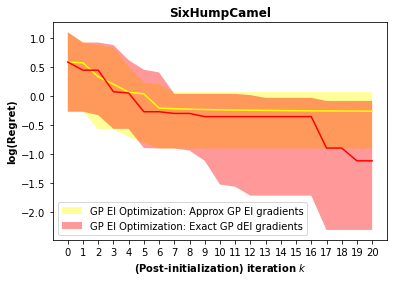

In [98]:
### Visualise!

title = func
plt.figure()

plt.plot(median_approx, color = 'Yellow')
plt.plot(median_exact, color = 'Red')

xstar = np.arange(0, iters+1, step=1)
plt.fill_between(xstar, lower_approx, upper_approx, facecolor = 'Yellow', alpha=0.4, label='GP EI Optimization: Approx GP EI gradients')
plt.fill_between(xstar, lower_exact, upper_exact, facecolor = 'Red', alpha=0.4, label='GP EI Optimization: Exact GP dEI gradients')

plt.title(title, weight = 'bold')
plt.xlabel('(Post-initialization) iteration $\it{k}$', weight = 'bold')
plt.ylabel('log(Regret)', weight = 'bold') 
plt.legend(loc=3) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(0, count))
plt.show() #visualize!

In [99]:
time_approx, time_exact


(678.0957970619202, 623.5541229248047)

In [100]:
### acqFunc attribute x, stddev: run number = 1

acqFuncApprox_exact_1 = acqFuncApprox(exact_1.history)
acqFuncExact_exact_1 = acqFuncExact(exact_1.history)

e1 = np.mean(acqFuncExact_exact_1)
a1 = np.mean(acqFuncApprox_exact_1)

e1, a1


(1.476675590863188, 1.5584127364136915)

In [101]:
### acqFunc attribute x, stddev: run number = 2

acqFuncApprox_exact_2 = acqFuncApprox(exact_2.history)
acqFuncExact_exact_2 = acqFuncExact(exact_2.history)

e2 = np.mean(acqFuncExact_exact_2)
a2 = np.mean(acqFuncApprox_exact_2)

e2, a2


(1.4996800213123533, 1.5993725151924005)

In [102]:
### acqFunc attribute x, stddev: run number = 3

acqFuncApprox_exact_3 = acqFuncApprox(exact_3.history)
acqFuncExact_exact_3 = acqFuncExact(exact_3.history)

e3 = np.mean(acqFuncExact_exact_3)
a3 = np.mean(acqFuncApprox_exact_3)

e3, a3


(1.367983575155535, 1.5008029325940317)

In [103]:
### acqFunc attribute x, stddev: run number = 4

acqFuncApprox_exact_4 = acqFuncApprox(exact_4.history)
acqFuncExact_exact_4 = acqFuncExact(exact_4.history)

e4 = np.mean(acqFuncExact_exact_4)
a4 = np.mean(acqFuncApprox_exact_4)

e4, a4


(1.469826818232934, 1.5393837630136897)

In [104]:
### acqFunc attribute x, stddev: run number = 5

acqFuncApprox_exact_5 = acqFuncApprox(exact_5.history)
acqFuncExact_exact_5 = acqFuncExact(exact_5.history)

e5 = np.mean(acqFuncExact_exact_5)
a5 = np.mean(acqFuncApprox_exact_5)

e5, a5


(1.46382647088558, 1.4066202692819973)

In [105]:
### acqFunc attribute x, stddev: run number = 6

acqFuncApprox_exact_6 = acqFuncApprox(exact_6.history)
acqFuncExact_exact_6 = acqFuncExact(exact_6.history)

e6 = np.mean(acqFuncExact_exact_6)
a6 = np.mean(acqFuncApprox_exact_6)

e6, a6


(1.6393378188417596, 1.5748614700485288)

In [106]:
### acqFunc attribute x, stddev: run number = 7

acqFuncApprox_exact_7 = acqFuncApprox(exact_7.history)
acqFuncExact_exact_7 = acqFuncExact(exact_7.history)

e7 = np.mean(acqFuncExact_exact_7)
a7 = np.mean(acqFuncApprox_exact_7)

e7, a7


(1.5062846109210342, 1.5111980459181527)

In [107]:
### acqFunc attribute x, stddev: run number = 8

acqFuncApprox_exact_8 = acqFuncApprox(exact_8.history)
acqFuncExact_exact_8 = acqFuncExact(exact_8.history)

e8 = np.mean(acqFuncExact_exact_8)
a8 = np.mean(acqFuncApprox_exact_8)

e8, a8


(1.366242572772194, 1.5646561314703007)

In [108]:
### acqFunc attribute x, stddev: run number = 9

acqFuncApprox_exact_9 = acqFuncApprox(exact_9.history)
acqFuncExact_exact_9 = acqFuncExact(exact_9.history)

e9 = np.mean(acqFuncExact_exact_9)
a9 = np.mean(acqFuncApprox_exact_9)

e9, a9


(1.4149994884753994, 1.4083379332711432)

In [109]:
### acqFunc attribute x, stddev: run number = 10

acqFuncApprox_exact_10 = acqFuncApprox(exact_10.history)
acqFuncExact_exact_10 = acqFuncExact(exact_10.history)

e10 = np.mean(acqFuncExact_exact_10)
a10 = np.mean(acqFuncApprox_exact_10)

e10, a10


(1.4544056107222438, 1.4460870988151509)

In [110]:
### acqFunc attribute x, stddev: run number = 11

acqFuncApprox_exact_11 = acqFuncApprox(exact_11.history)
acqFuncExact_exact_11 = acqFuncExact(exact_11.history)

e11 = np.mean(acqFuncExact_exact_11)
a11 = np.mean(acqFuncApprox_exact_11)

e11, a11


(1.3974414186307933, 1.4265780662520717)

In [111]:
### acqFunc attribute x, stddev: run number = 12

acqFuncApprox_exact_12 = acqFuncApprox(exact_12.history)
acqFuncExact_exact_12 = acqFuncExact(exact_12.history)

e12 = np.mean(acqFuncExact_exact_12)
a12 = np.mean(acqFuncApprox_exact_12)

e12, a12


(1.4980559065199122, 1.473503874980056)

In [112]:
### acqFunc attribute x, stddev: run number = 13

acqFuncApprox_exact_13 = acqFuncApprox(exact_13.history)
acqFuncExact_exact_13 = acqFuncExact(exact_13.history)

e13 = np.mean(acqFuncExact_exact_13)
a13 = np.mean(acqFuncApprox_exact_13)

e13, a13


(1.4776308484427374, 1.5820638801596878)

In [113]:
### acqFunc attribute x, stddev: run number = 14

acqFuncApprox_exact_14 = acqFuncApprox(exact_14.history)
acqFuncExact_exact_14 = acqFuncExact(exact_14.history)

e14 = np.mean(acqFuncExact_exact_14)
a14 = np.mean(acqFuncApprox_exact_14)

e14, a14


(1.4807385309784702, 1.4374074280158493)

In [114]:
### acqFunc attribute x, stddev: run number = 15

acqFuncApprox_exact_15 = acqFuncApprox(exact_15.history)
acqFuncExact_exact_15 = acqFuncExact(exact_15.history)

e15 = np.mean(acqFuncExact_exact_15)
a15 = np.mean(acqFuncApprox_exact_15)

e15, a15


(1.4900536935428648, 1.5076008114491313)

In [115]:
### acqFunc attribute x, stddev: run number = 16

acqFuncApprox_exact_16 = acqFuncApprox(exact_16.history)
acqFuncExact_exact_16 = acqFuncExact(exact_16.history)

e16 = np.mean(acqFuncExact_exact_16)
a16 = np.mean(acqFuncApprox_exact_16)

e16, a16


(1.5020185004871975, 1.5155143575360106)

In [116]:
### acqFunc attribute x, stddev: run number = 17

acqFuncApprox_exact_17 = acqFuncApprox(exact_17.history)
acqFuncExact_exact_17 = acqFuncExact(exact_17.history)

e17 = np.mean(acqFuncExact_exact_17)
a17 = np.mean(acqFuncApprox_exact_17)

e17, a17


(1.437114338653251, 1.403332844011079)

In [117]:
### acqFunc attribute x, stddev: run number = 18

acqFuncApprox_exact_18 = acqFuncApprox(exact_18.history)
acqFuncExact_exact_18 = acqFuncExact(exact_18.history)

e18 = np.mean(acqFuncExact_exact_18)
a18 = np.mean(acqFuncApprox_exact_18)

e18, a18


(1.442749128490599, 1.4732867131564393)

In [118]:
### acqFunc attribute x, stddev: run number = 19

acqFuncApprox_exact_19 = acqFuncApprox(exact_19.history)
acqFuncExact_exact_19 = acqFuncExact(exact_19.history)

e19 = np.mean(acqFuncExact_exact_19)
a19 = np.mean(acqFuncApprox_exact_19)

e19, a19


(1.428714441040094, 1.45848744752597)

In [119]:
### acqFunc attribute x, stddev: run number = 20

acqFuncApprox_exact_20 = acqFuncApprox(exact_20.history)
acqFuncExact_exact_20 = acqFuncExact(exact_20.history)

e20 = np.mean(acqFuncExact_exact_20)
a20 = np.mean(acqFuncApprox_exact_20)

e20, a20


(1.4510673591225325, 1.4482211294157254)

In [120]:
### Summarize arrays: 

exact_stddev = np.sort([e1,e2,e3,e4,e5,e6,e7,e8,e9,e10,e11,e12,e13,e14,e15,e16,e17,e18,e19,e20])
approx_stddev = np.sort([a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16,a17,a18,a19,a20])

np.mean(exact_stddev), np.mean(approx_stddev)


(1.4632423372045338, 1.4917864724260552)

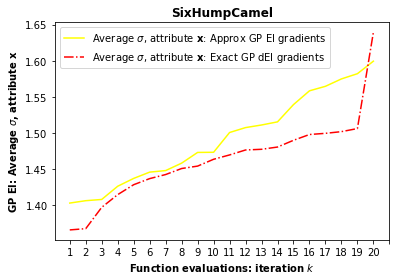

In [121]:
### Visualise!

title = func
plt.figure()

plt.plot(approx_stddev, color = 'Yellow', ls='-', label='Average $\sigma$, attribute $\mathbf{x}$: Approx GP EI gradients')
plt.plot(exact_stddev, color = 'Red', ls='-.', label='Average $\sigma$, attribute $\mathbf{x}$: Exact GP dEI gradients')

plt.title(title, weight = 'bold')
plt.xlabel('Function evaluations: iteration $\it{k}$', weight = 'bold')
plt.ylabel('GP EI: Average $\sigma$, attribute $\mathbf{x}$', weight = 'bold') 
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count))
plt.show() #visualize!
